In [2]:
import os
import ROOT
import numpy as np
import pandas as pd
import re

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axis as ax
from matplotlib.colors import LogNorm
from multihist import Hist1d, Histdd

from scipy.optimize import curve_fit
import scipy.stats as sps
%matplotlib inline

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['image.cmap'] = 'viridis'
#see the AP(copy) and save!!!!! the fit parameters (res)

In [5]:
path = "/home/cristian/Suxess_files/data/run6/gas/ap180306/"
path1="/home/cristian/Suxess_files/data/run6/gas/ap180301/"
#board=0
#channel=3
os.listdir(path)

['processed_wf0_Board0_AP_LED_2.31V.root',
 'processed_wf2_Board0_AP_LED_2.53V.root',
 'processed_wf1_Board0_AP_LED_2.48V.root',
 'processed_wf0_Board1_AP_LED_2.33V.root',
 'processed_wf3_Board0_AP_LED_2.33V.root',
 'processed_wf3_Board1_AP_LED_2.41V.root',
 'processed_wf2_Board1_AP_LED_2.48V.root',
 'processed_wf6_Board0_AP_LED_2.41V.root',
 'processed_wf1_Board1_AP_LED_2.41V.root',
 'AP_figs',
 'processed_wf4_Board1_AP_LED_2.41V.root',
 'processed_wf5_Board0_AP_LED_2.33V.root',
 'processed_wf4_Board0_AP_LED_2.41V.root',
 'processed_wf6_Board1_AP_LED_2.45V.root',
 'processed_wf5_Board1_AP_LED_2.36V.root']

In [6]:
path_of_files2 = os.listdir(path1)
os.listdir(path1)


['processed_wf5_Board0_AP_LED_2.34V.root',
 'processed_wf4_Board1_AP_LED_2.42V.root',
 'processed_wf2_Board1_AP_LED_2.49V.root',
 'processed_wf3_Board0_AP_LED_2.34V.root',
 'processed_wf0_Board0_AP_LED_2.32V.root',
 'processed_wf3_Board1_AP_LED_2.42V.root',
 'processed_wf2_Board0_AP_LED_2.54V.root',
 'processed_wf1_Board0_AP_LED_2.49V.root',
 'processed_wf4_Board0_AP_LED_2.43V.root',
 'processed_wf1_Board1_AP_LED_2.43V.root',
 'processed_wf5_Board1_AP_LED_2.37V.root',
 'processed_wf6_Board0_AP_LED_2.42V.root',
 'processed_wf6_Board1_AP_LED_2.46V.root',
 'processed_wf0_Board1_AP_LED_2.34V.root']

In [7]:
elem_charge = 1.6021766e-19

def area_to_charge(a):
    # area in adc counts * 10 * ns
    factor = 2.25 * 10e-9 / (2**14 * 50) #  * elem_charge)
    return factor * (a / 10)

In [8]:
def process_ap_file(filename):
    file = ROOT.TFile(filename)
    tree = file.Get('T1')

    pos = []
    area = []
    #entropy = []
    height = []
    width50 = []
    for event in tqdm(file.Get('T1')):
        if len(event.Position)>0:
            for p in event.Position:
                pos.append(p)
        if len(event.Area)>0:        
            for a in event.Area:
                area.append(a)
        #for e in event.Entropy:
          #  entropy.append(e)
        if len(event.Height)>0:
            for h in event.Height:
                height.append(h)
        if len(event.Width50)>0:        
            for w in event.Width50:
                width50.append(w)
    d = {'time': np.array(pos),
        'area': area_to_charge(np.array(area))/(5e6 * elem_charge),
        'height': np.array(height),
        'width50':np.array(width50)}
    df = pd.DataFrame(d)
    t0_df=df[df['area']>100]
    t0 = np.mean(t0_df.time)
    d={'time': np.array((pos-t0)/100),
       'area': area_to_charge(np.array(area))/(5e6 * elem_charge),
       'height': np.array(height),
       'width50': np.array(width50)}
    df = pd.DataFrame(d)
    #print (df[df['area']<0])
    #print(df[df['area']==0])
    return df

In [9]:
def plot_hw(data_frame, pmt):
    #data_frame = data_frame[(data_frame['area']>=0) & (data_frame['time']>-0.1)]
    plt.figure(figsize=(10,6))
    #data_frame1=data_frame[data_frame['entropy']<0.4]
    #print(data_frame)
    #data_frame1=data_frame[((data_frame['height']>300)|(data_frame['width50']<10))]
    counts, binx, biny,_ =plt.hist2d(data_frame['width50'], data_frame['height'], bins=(60,500), range=((0, 60), (0,500)), norm=LogNorm()) #bins 200
    plt.colorbar(label='counts')
    plt.xlabel('width (*10 ns)')
    plt.ylabel('height (ADC)')
    plt.title('PMT %d' % pmt)
    #plt.savefig(path+ 'AP_figs/' + 'ap_pmt%d_run2_gas.png' % pmt, dpi=150)
    plt.show()
    """plt.clf()
    plt.figure(figsize=(10,6))
    plt.imshow(counts.T, interpolation= 'none', origin='lower', aspect = 'equal', norm=LogNorm() )
    plt.colorbar(label='counts')
    plt.show()"""

In [15]:
def estimateArPosition(V):
    R2 = 72.6e6 #resistence after photocatode
    R1 = 92.6e6 #Total resistence
    
    fV = V - (V*R2)/R1
    ArPeak = 29.4402*np.sqrt(1/fV)
    return ArPeak - 0.07

def estimateXePosition(V):
    R2 = 72.6e6 #resistence after photocatode
    R1 = 92.6e6 #Total resistence
    fV = V - (V*R2)/R1
    XePeak = 53.2778*np.sqrt(1/fV)
    return XePeak - 0.11


def plot(data_frame, pmt, valHV5e6, path):
    #data_frame = data_frame[(data_frame['area']>=0) & (data_frame['time']>-0.1)]
    plt.figure(figsize=(10,6))
    #data_frame1=data_frame[((data_frame['height']<100)|(data_frame['width50']>4))]
    #print(data_frame)
    counts, _,_,_= plt.hist2d(data_frame['time'], data_frame['area'], bins=(550,500), range=((-0.5, 5), (0,50)), norm=LogNorm(), normed = False) #bins 200
    plt.colorbar(label='counts')
    XePeak = estimateXePosition(valHV5e6)
    ArPeak = estimateArPosition(valHV5e6)
    line_up = plt.axvline(ArPeak, color='b', linestyle='dashed', linewidth=2, label= 'Ar peak estimate')
    line_down = plt.axvline(XePeak, color='red', linestyle='dashed', linewidth=2, label ='Xe peak estimate')
    plt.legend(handles=[line_up, line_down])
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Area [pe]')
    plt.title('PMT %d' % pmt)
    #plt.savefig(path+ 'AP_figs/' + 'ap_pmt%d_run5_liquid_gain_studies.png' % pmt, dpi=150, transparent = False)
    plt.show()
    return counts

In [11]:
def to_pmt(board, channel):
    if board == 0:
        return channel + 1
    if board == 1 and channel==6:
        return 8
    if board ==1 and channel!=6:
        return channel+9

In [30]:
hist_old=[]
hist_new=[]
arHV5e6 = [1428.6,1352.8,1360.8,1487.1, 1443.2,1451.0,1422.4,1429.3,1378.7,1430.0,1432.7,1374.0,1365.0,1447.9] #run6 gas
#[1445.6,1375.1,1450,1350.2,1500.1,1452.9,1406.8,1406.2,1406.8,1402.4,1340.7,1344.5,1382.9,1402.0] # insert the numerical values for the 5e6HV

#arHV5e6 = [1405.3,1365.4,1398.7,1397.4,1400.0,1344.1,1377.5,1373.5,1389.6,1374.5,1312.1,1340.2,1368.3,1382.9] # insert the numerical values for the 5e6HV
arr=np.array(arHV5e6)

for file in os.listdir(path):
    if 'counts' in file:
        continue
    if 'AP_figs' in file:
        continue
    print(file)
    channel = int(file.split("_")[1].lstrip("wf"))
    board = int(file.split("_")[2].lstrip("Board"))
    pmt = channel + 1 + board * 7
    
    #print(channel,board, pmt)
    my_regex = r"(processed_wf"+ str(channel) + r"_Board" + str(board) +r"_AP_LED_*)"
    for file0 in path_of_files2: 
        if re.search(my_regex, file0) :
            file1 = file0
    AP_data = process_ap_file(path + file)
    AP_data_old = process_ap_file(path1 + file1)
    #plot_hw(AP_data,pmt)
    #hist_new=plot(AP_data, pmt, arr[pmt-1], path)
    #hist_old=plot(AP_data_old, pmt,arr[pmt-1], path1)
    hist_diff = np.subtract(hist_new, hist_old)

    plt.figure(figsize=(10,6))
    #plt.imshow(hist_diff.T, interpolation= 'none', origin='lower', aspect = 'auto', norm=LogNorm(), extent=[-0.5,5,0,50] )
    plt.colorbar(label='counts')
    XePeak = estimateXePosition(arr[pmt-1])
    ArPeak = estimateArPosition(arr[pmt-1])
    line_up=plt.axvline(ArPeak, color='b', linestyle='dashed', linewidth=2, label = 'Ar peak estimate')
    line_down=plt.axvline(XePeak, color='red', linestyle='dashed', linewidth=2, label = 'Xe peak estimate')
    plt.legend(handles=[line_up, line_down])
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Area [pe]')
    plt.title('PMT '+str(pmt)+ 'difference')
    #plt.savefig(path + 'ap_pmt%d_run2_vacuum_difference.png' % pmt, dpi=150, transparent = False)
    plt.show()
    
    
"""for file1 in os.listdir(path1):
    if 'counts' in file1:
        continue
    if 'AP_figs' in file1:
        continue
    print(file1)
    channel = int(file1.split("_")[1].lstrip("wf"))
    board = int(file1.split("_")[2].lstrip("Board"))
    pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

    AP_data1 = process_ap_file(path1 + file1)
    #plot_hw(AP_data,pmt)
    hist_old.append(plot(AP_data1, pmt))"""

1721it [00:00, 17200.99it/s]

processed_wf4_Board0_AP_LED_2.95V.root


34026it [00:01, 24293.45it/s]


KeyboardInterrupt: 

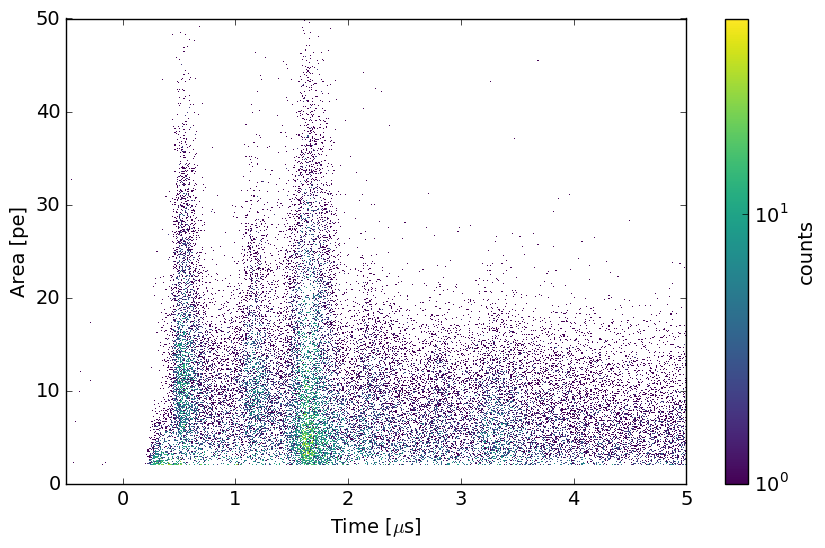

In [ ]:
##############      SKIP TO LAST CELL IF YOU ONLY WANT THE COUNTS    ################

In [10]:
def fit_exp(x, N, a, c1, c2):
    return N*np.exp(-a*x + c1) + c2

arHV5e6 = [1428.6,1352.8,1360.8,1487.1, 1443.2,1451.0,1422.4,1429.3,1378.7,1430.0,1432.7,1374.0,1365.0,1447.9] #run6 gas
#[1445.6,1375.1,0,1450.2,1417.1,1352.9,1406.8,1406.2,1406.8,1402.4,1340.7,1344.5,1382.9,1402.0] # insert the numerical values for the 5e6HV


def plot1dhist(data_frame,pmt,func, valHV5e6, path):
    plt.figure(figsize=(10,6))
    #data_frame1=data_frame[((data_frame['area']>2)&(data_frame['width50']<4))]
    data_frame1=data_frame[(data_frame['area']<50)]
    weights = np.ones_like(data_frame1['time'])/float(len(data_frame['time'])) # normalized to ALL events (above 2pe th.)
    h, bin_edges, _= plt.hist( data_frame1['time'], bins=500, range=((0, 5)), normed = False, weights = weights) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[(histDF['bin_centres']<1.3) | (histDF['bin_centres']>4)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    #res = curve_fit(func, bin_centers, h1, p0=[500,1, 1, 0])
    XePeak = estimateXePosition(valHV5e6)
    ArPeak = estimateArPosition(valHV5e6)
    line_up=plt.axvline(ArPeak, color='b', linestyle='dashed', linewidth=2, label = "Ar peak estimate")
    #plt.text((ArPeak+0.1),0.005,'Ar estimate',rotation=90)
    line_down=plt.axvline(XePeak, color='red', linestyle='dashed', linewidth=2, label = "Xe peak estimate")
    plt.legend(handles=[line_up, line_down])
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Events/Triggers')
    plt.title('PMT %d' % pmt)
    #plt.plot(bin_centres, func(bin_centres, *res[0]))
    #plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_run3_gas.png' % pmt, dpi=150, transparent=False)
    plt.show()
    plt.clf()
    return D
    """residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp-fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-100,200])
    #plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_expfit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()
    """

1000000it [00:38, 25652.41it/s]
1000000it [00:38, 25884.51it/s]


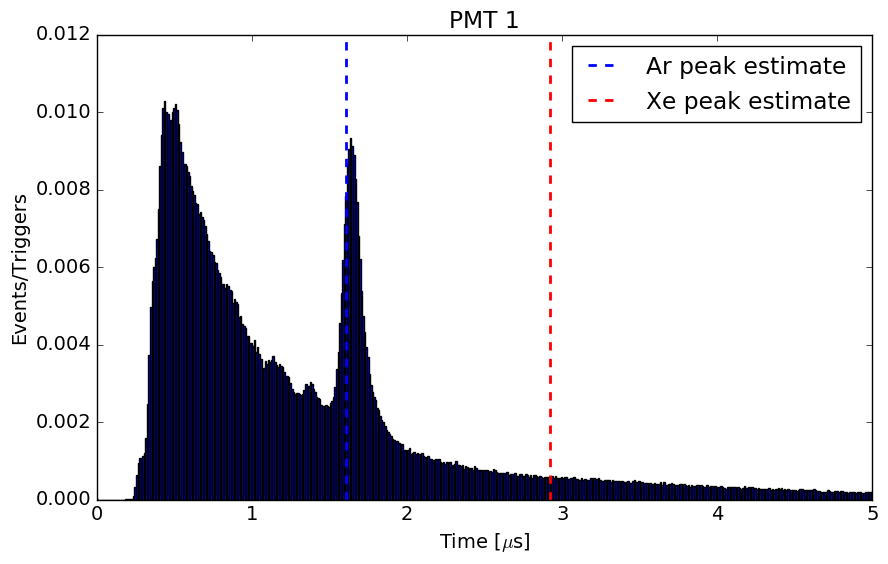

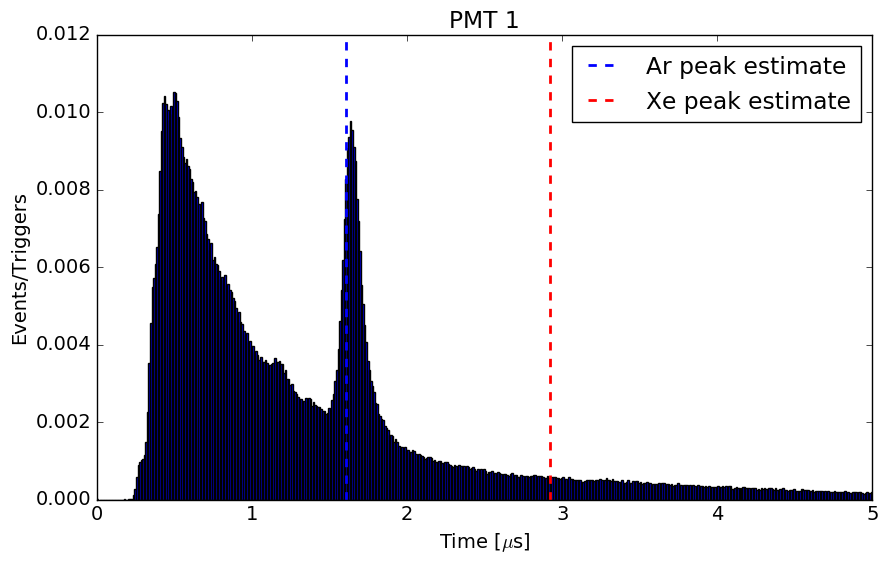

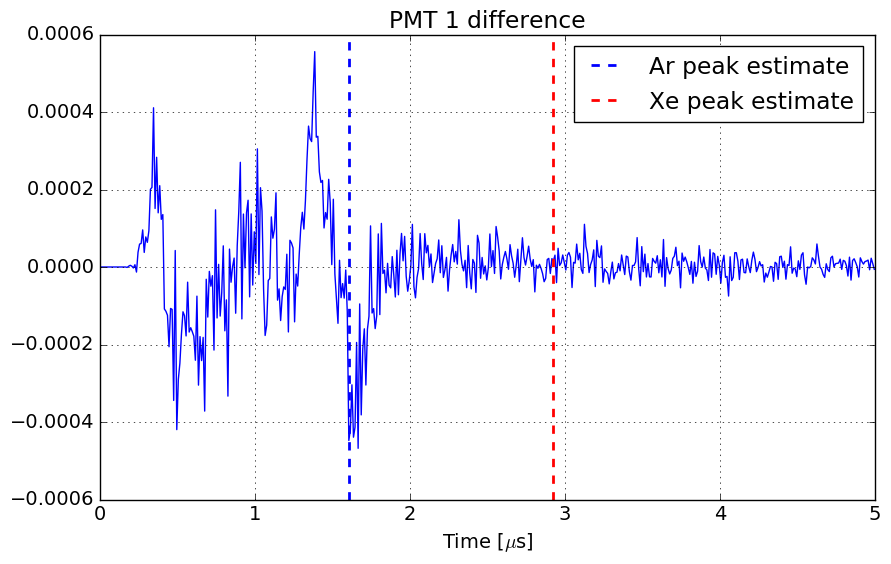

1000000it [00:42, 23376.40it/s]
1000000it [00:47, 20907.69it/s]


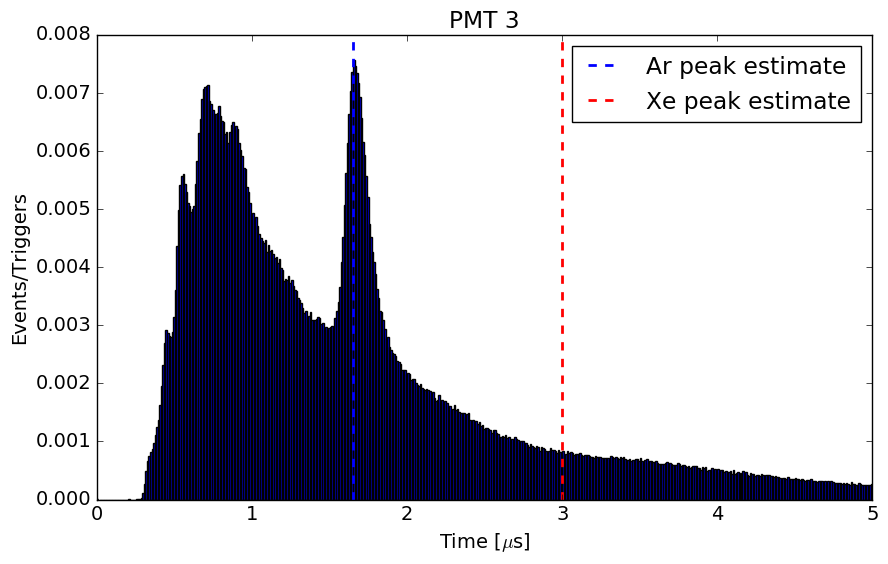

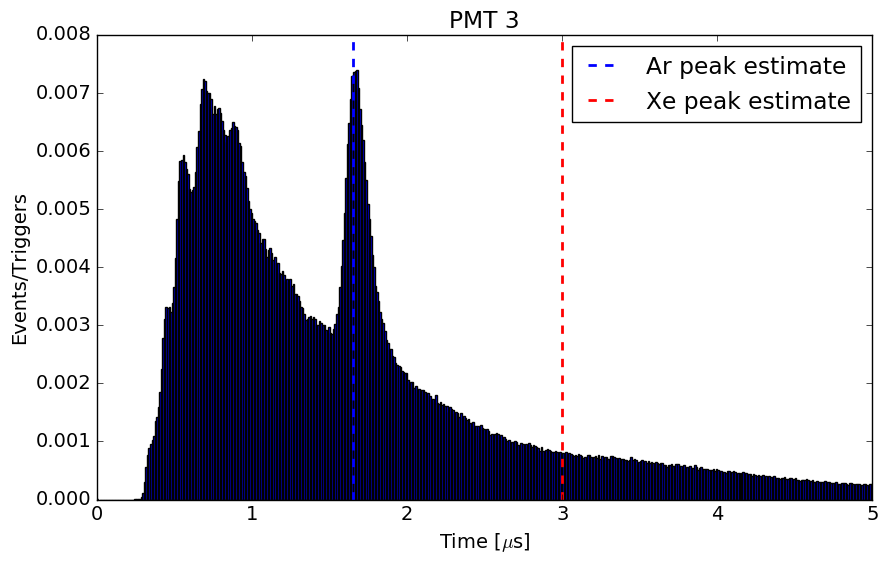

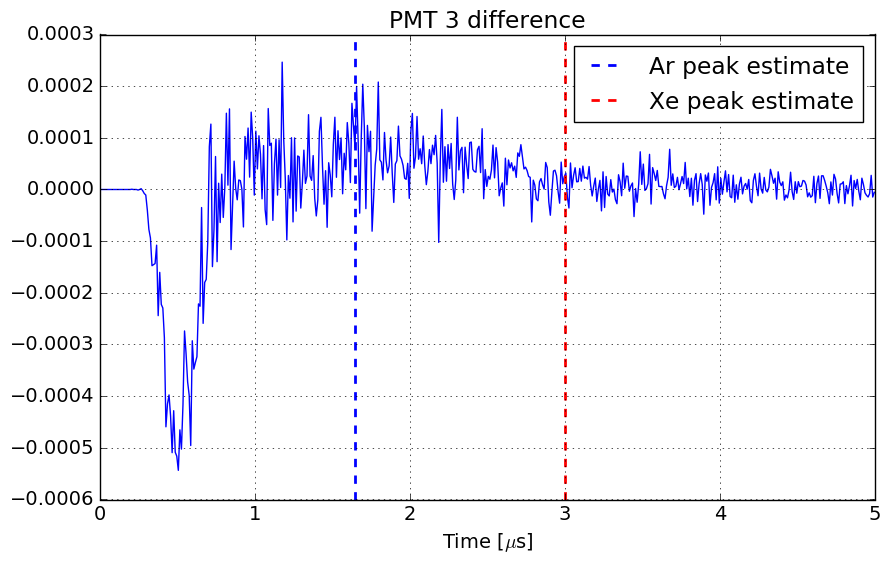

1000000it [00:45, 21935.55it/s]
1000000it [00:47, 20906.83it/s]


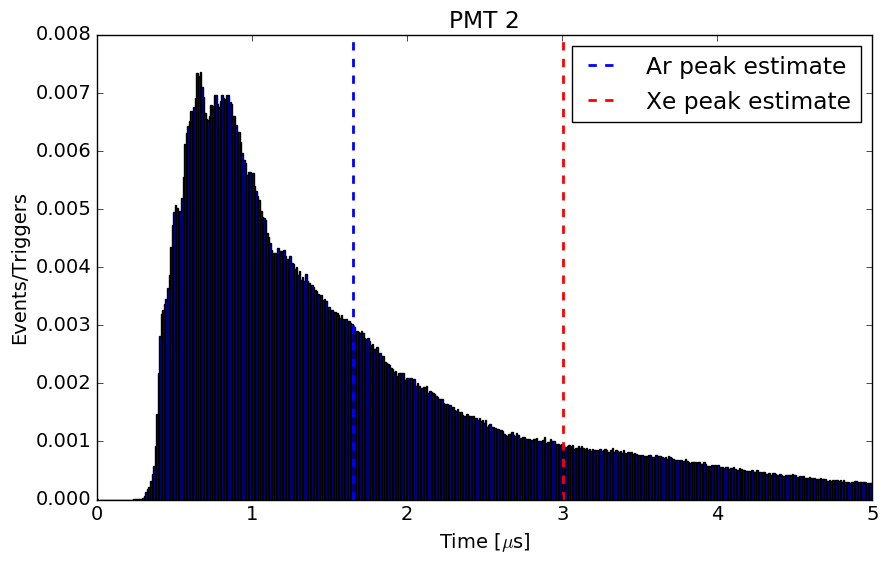

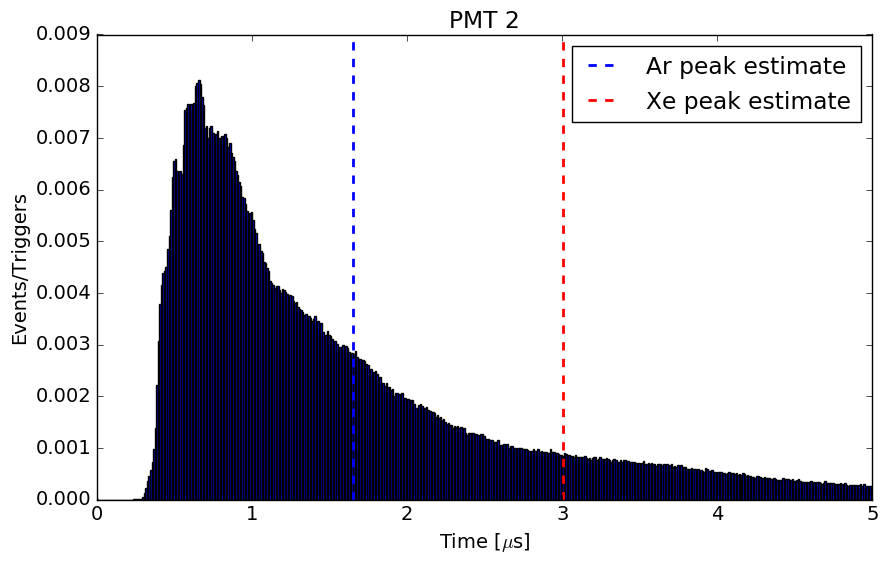

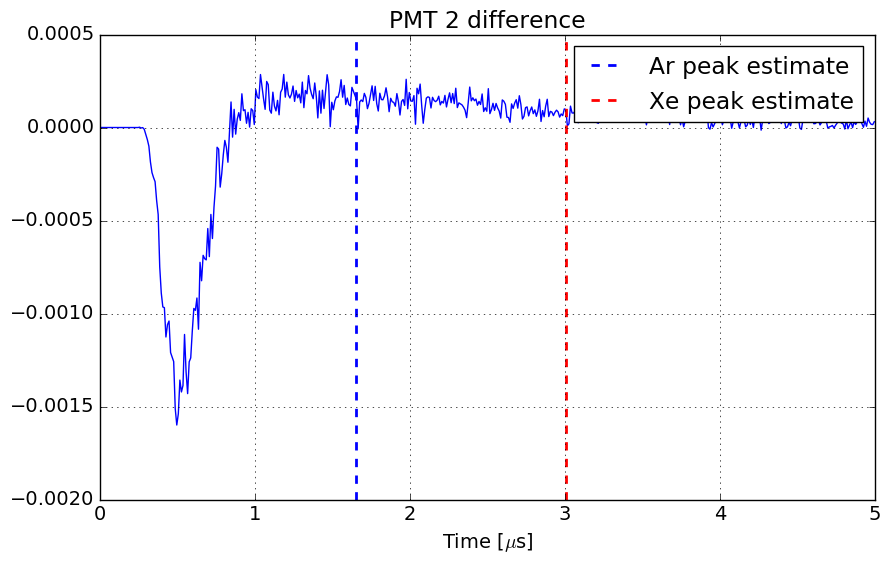

1000000it [00:43, 23240.95it/s]
1000000it [00:43, 23236.13it/s]


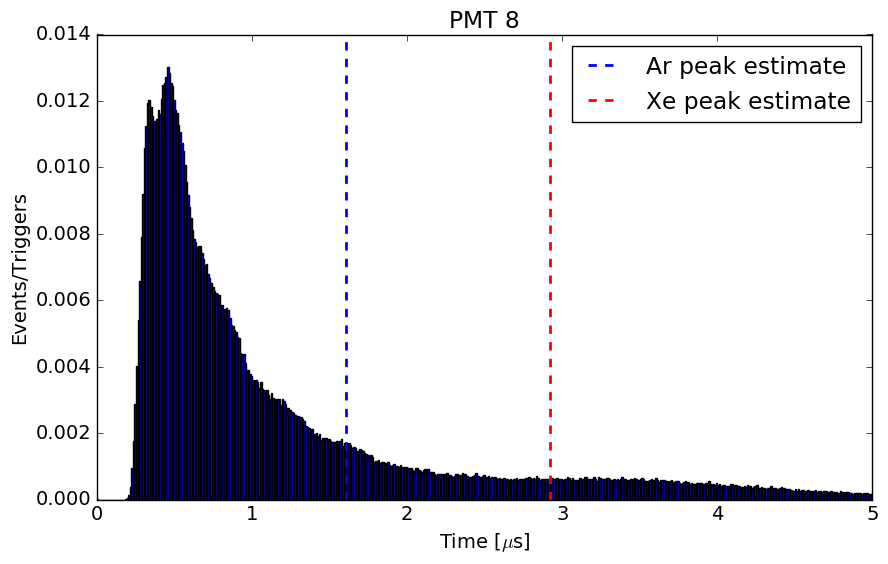

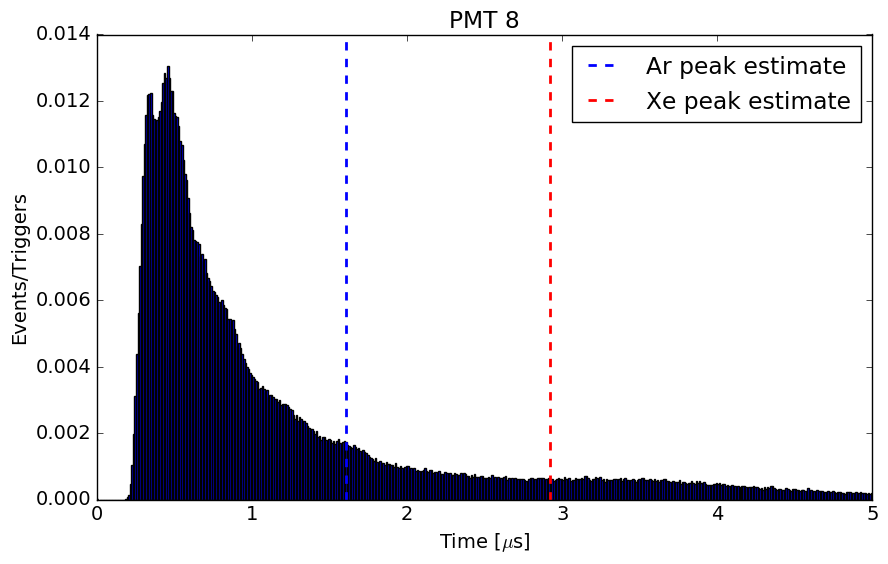

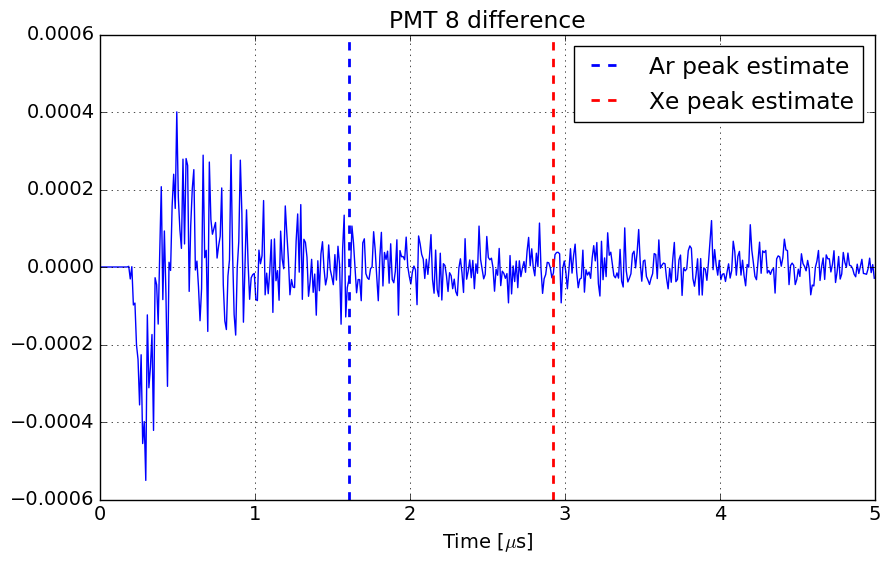

1000000it [00:39, 25220.75it/s]
1000000it [00:43, 23188.94it/s]


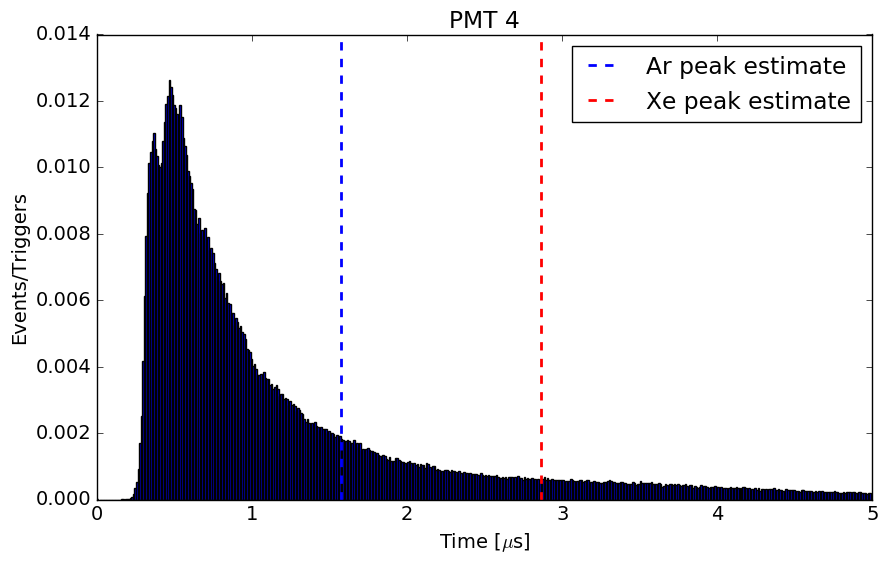

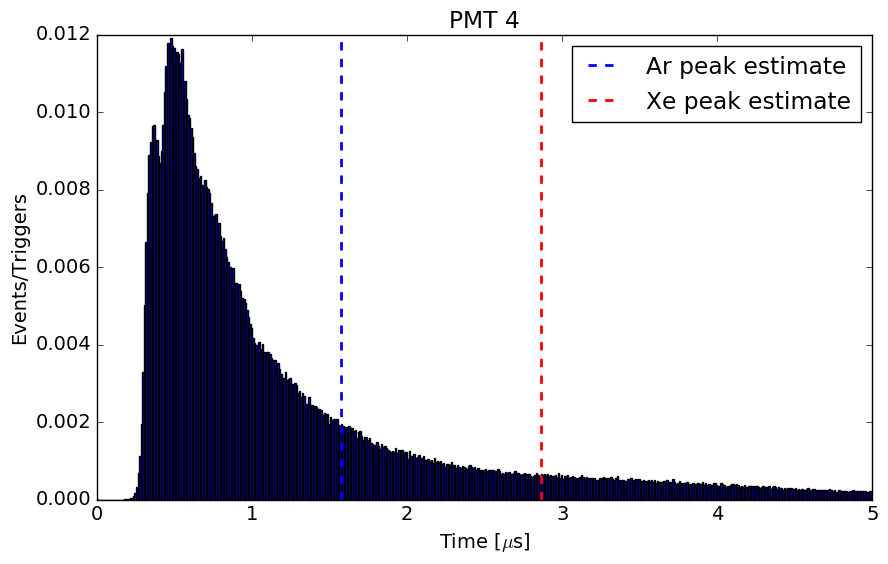

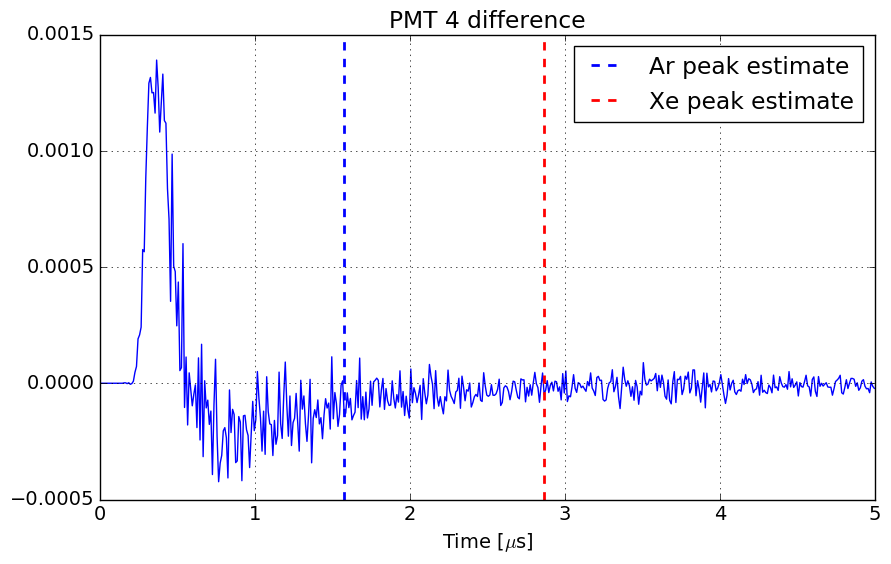

1000000it [00:47, 21189.36it/s]
1000000it [00:45, 21744.90it/s]


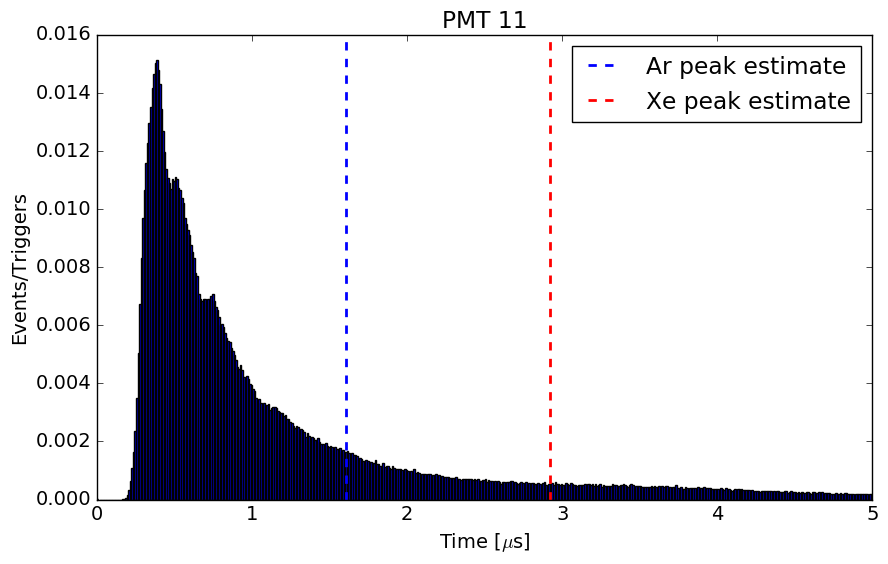

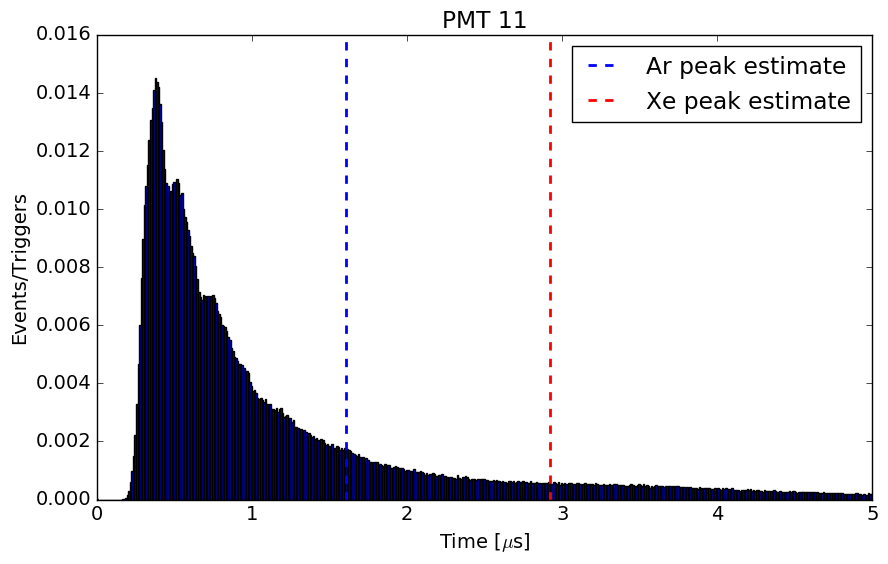

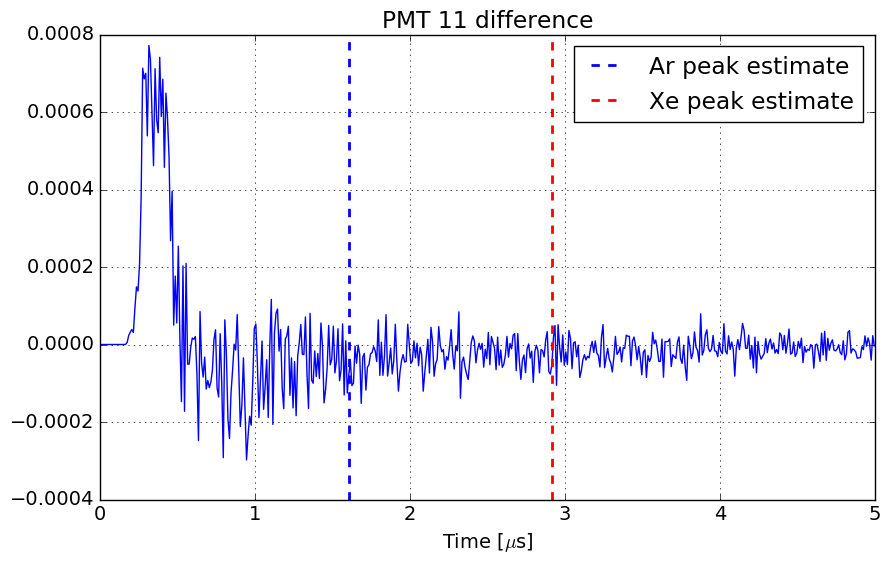

1000000it [00:41, 24037.81it/s]
1000000it [00:49, 20252.54it/s]


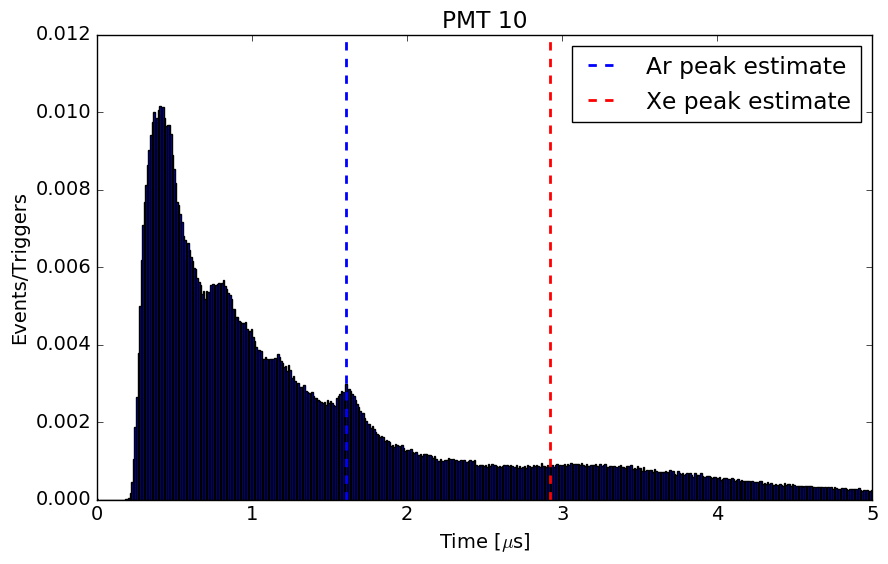

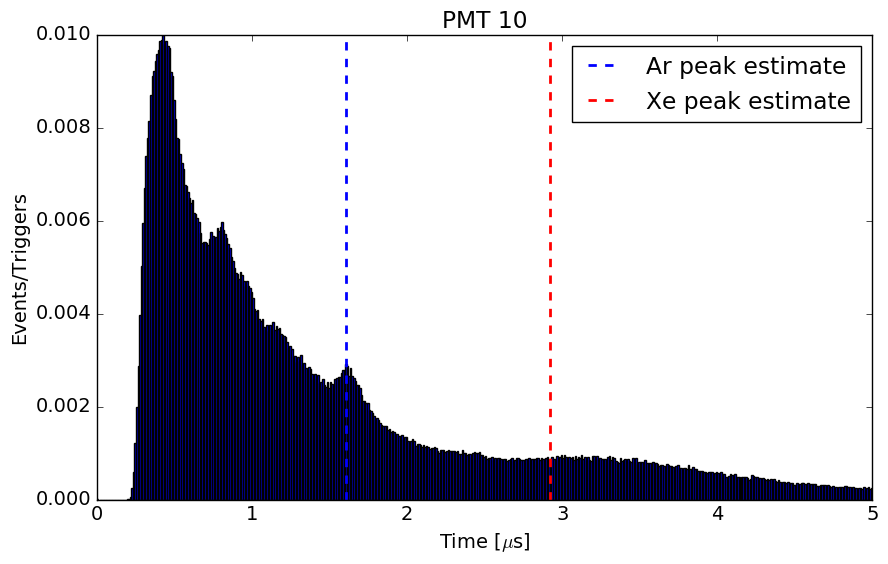

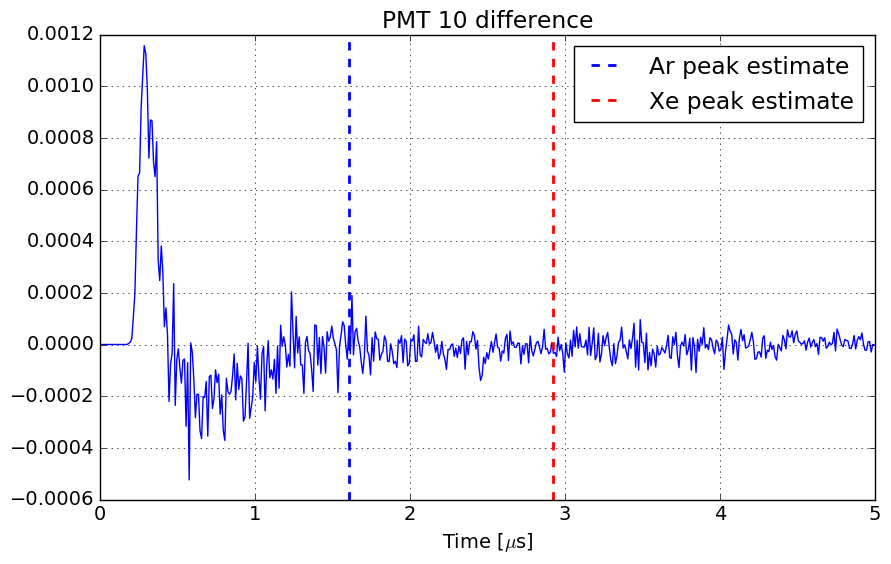

1000000it [00:46, 21468.81it/s]
1000000it [00:46, 21630.11it/s]


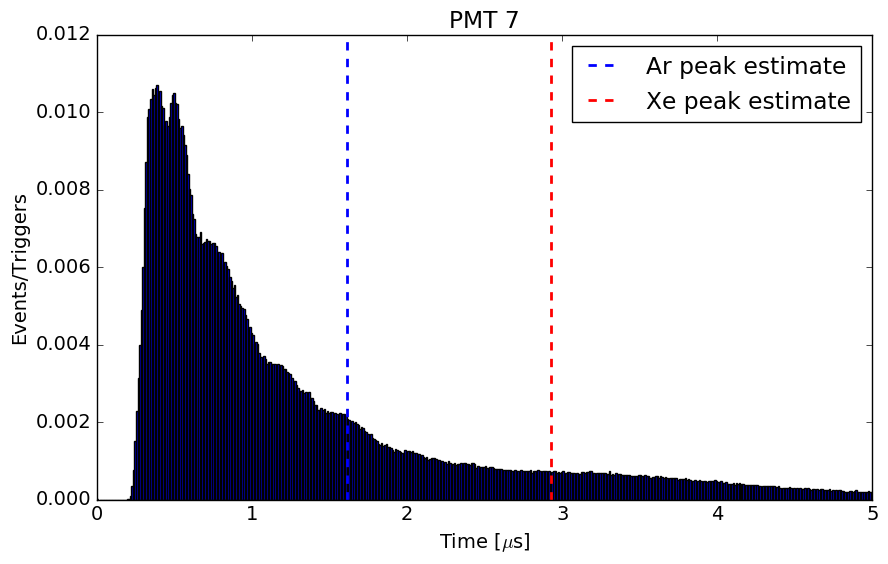

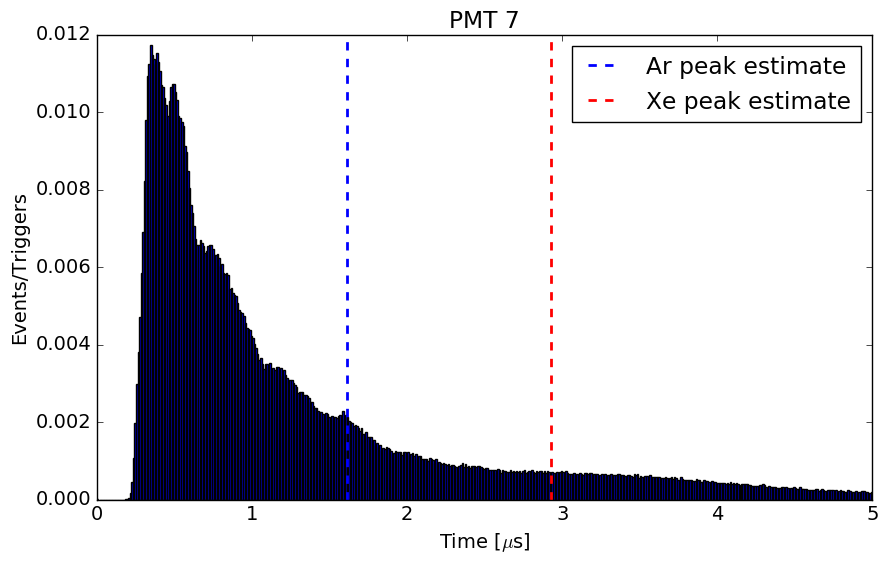

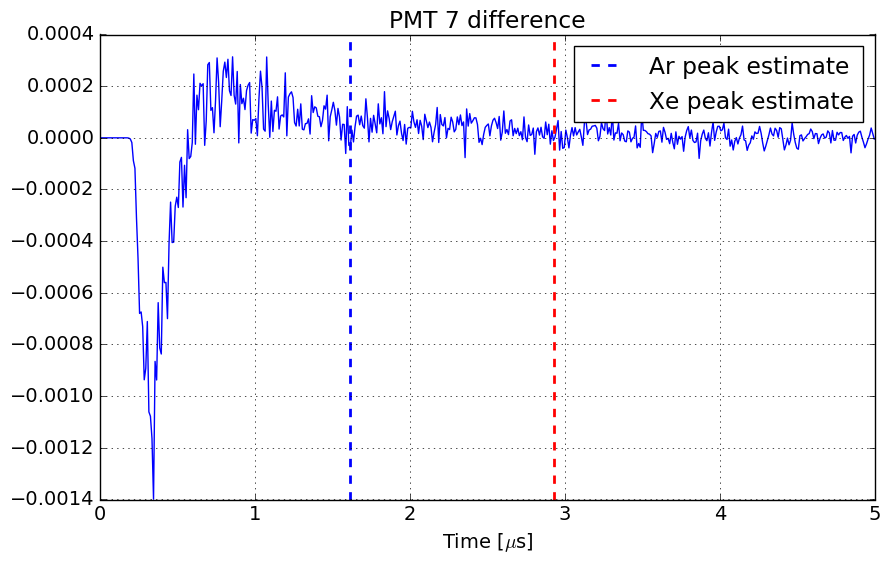

1000000it [00:44, 22492.63it/s]
1000000it [00:45, 22140.20it/s]


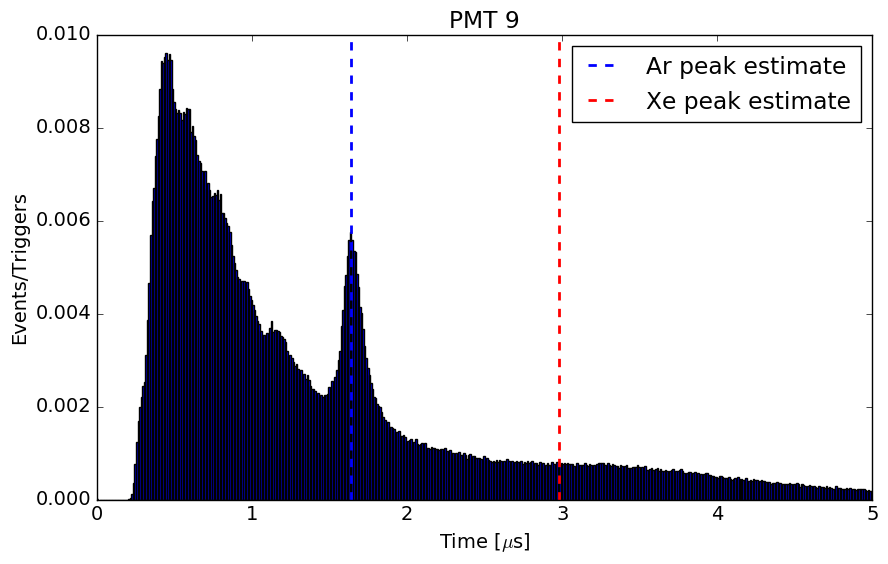

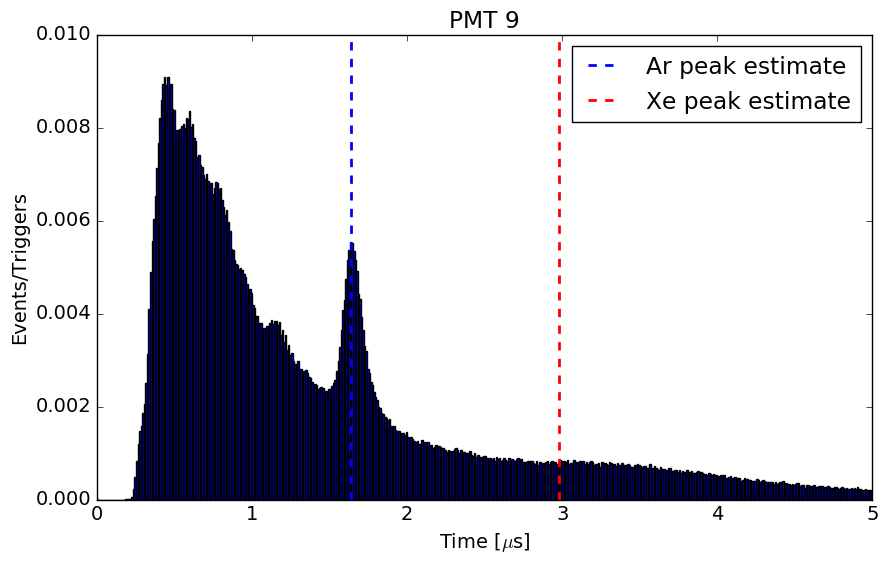

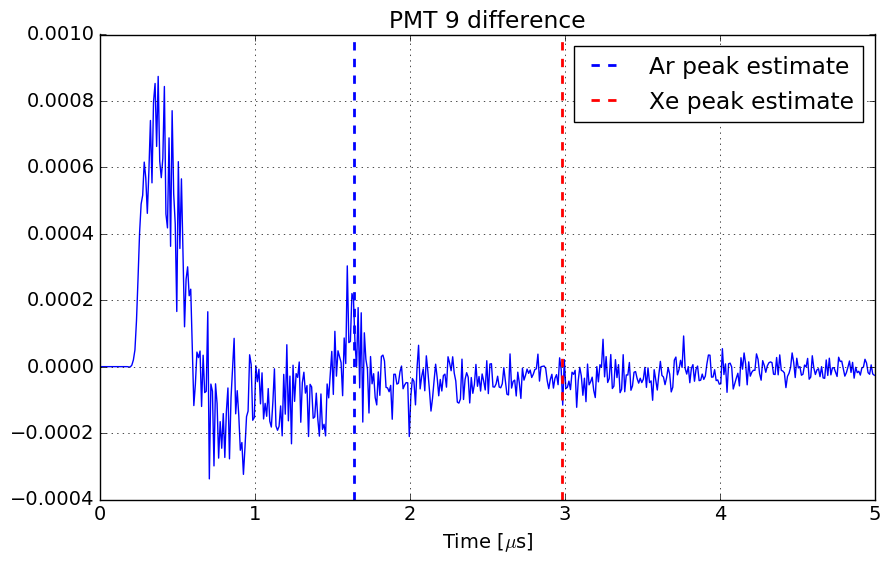

1000000it [00:40, 24813.10it/s]
1000000it [00:43, 23083.72it/s]


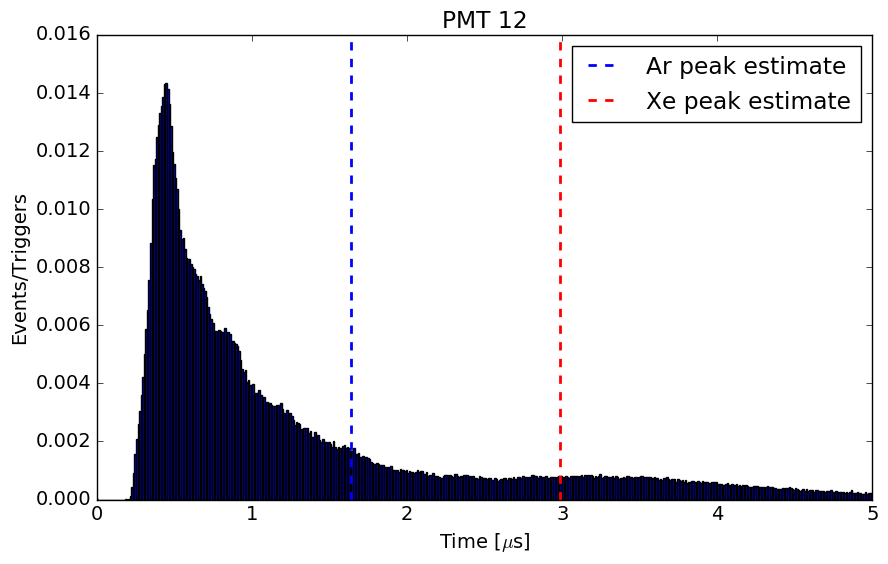

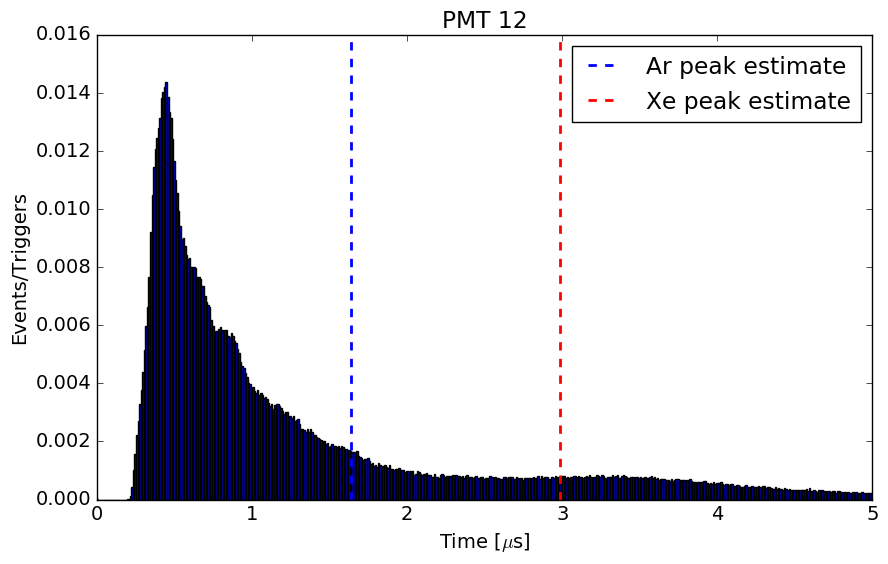

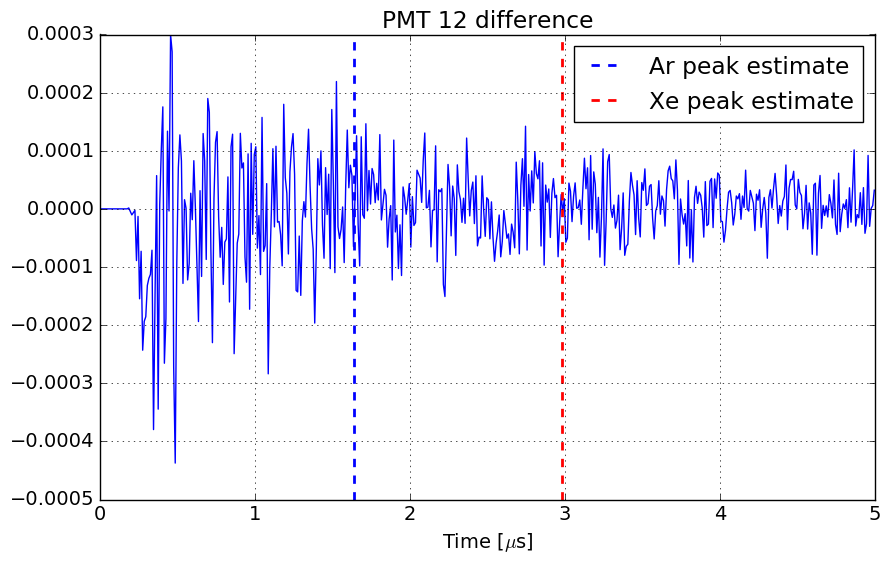

1000000it [00:39, 25166.48it/s]
1000000it [00:42, 23499.95it/s]


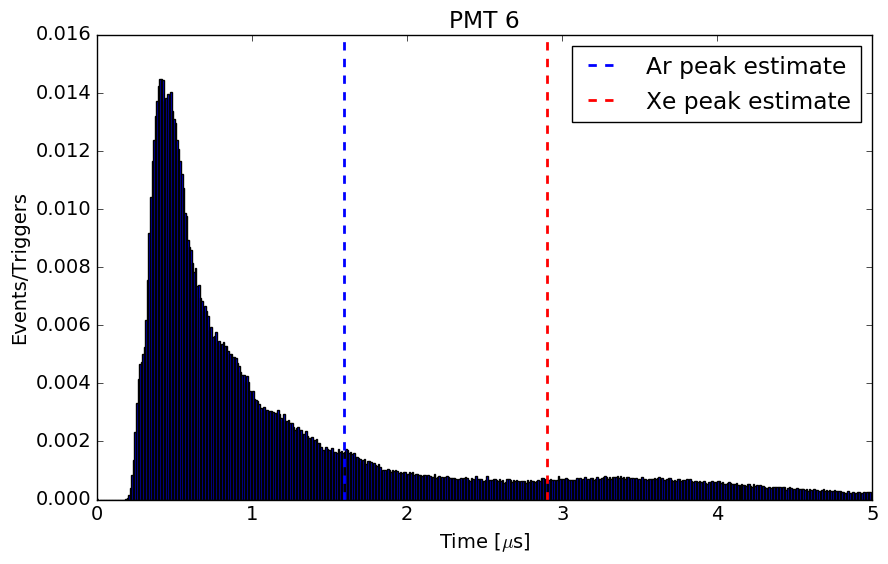

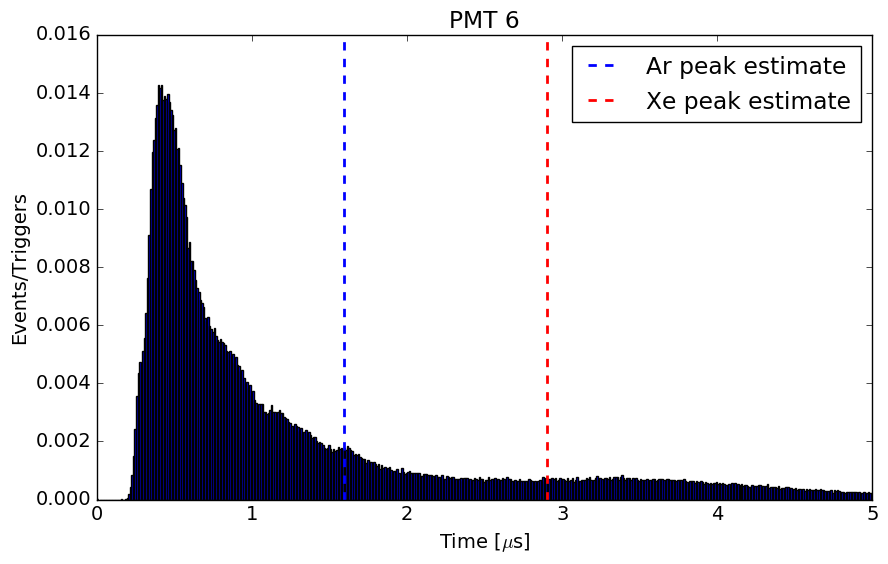

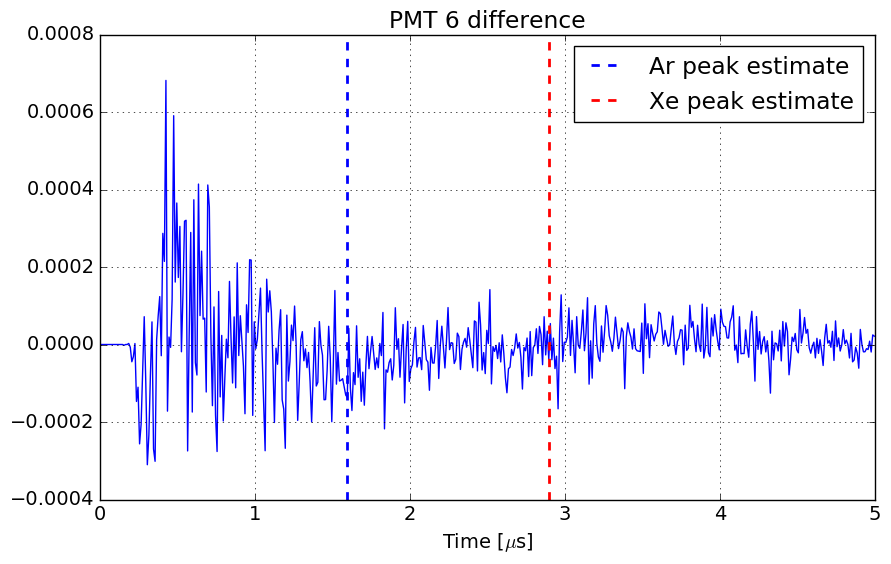

1000000it [00:38, 26241.04it/s]
1000000it [00:41, 23987.75it/s]


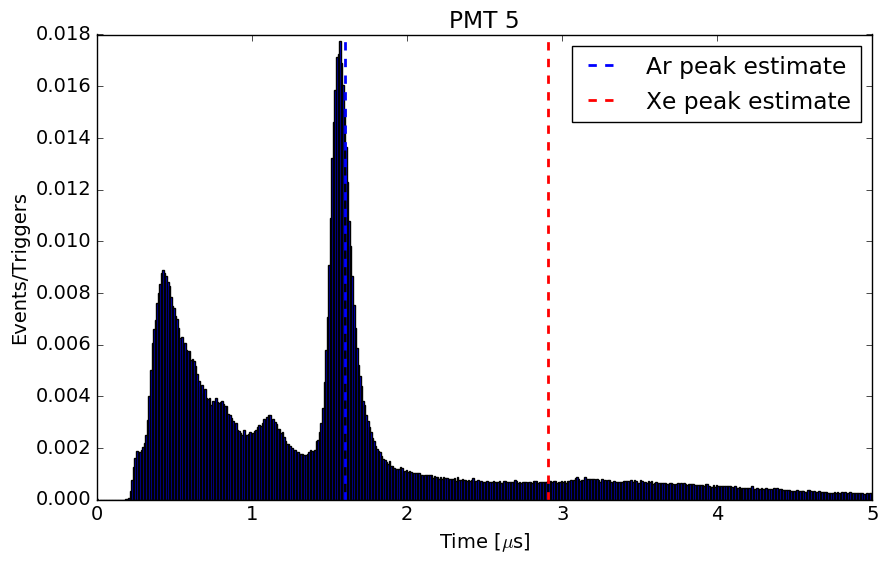

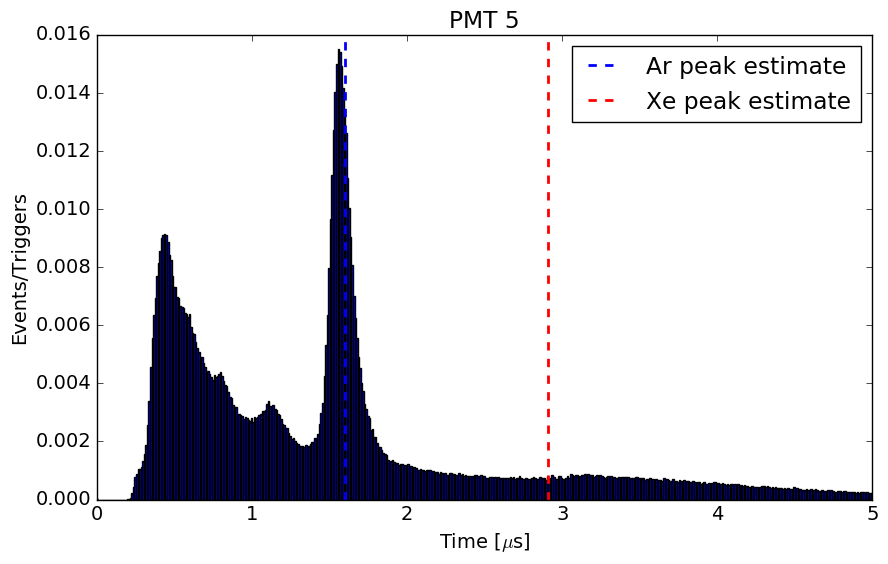

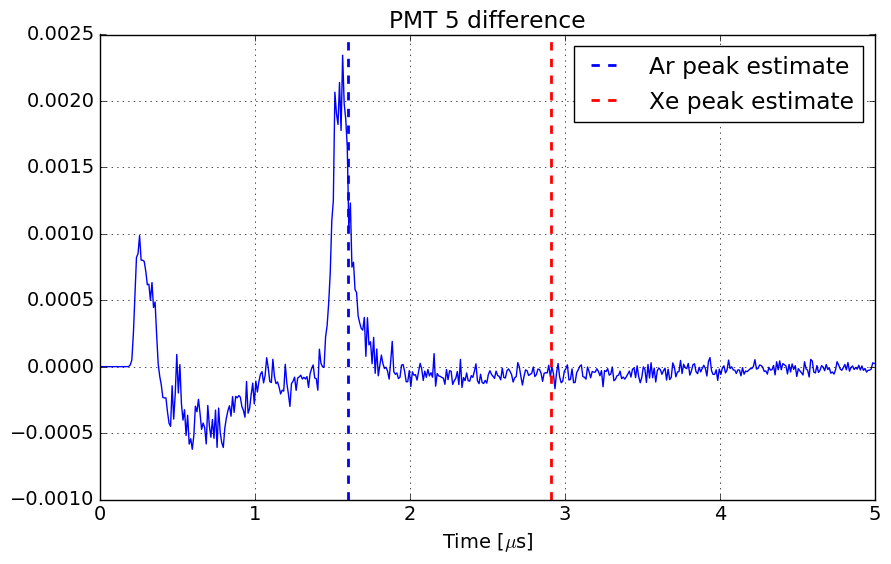

1000000it [00:41, 24068.61it/s]
1000000it [00:44, 22458.83it/s]


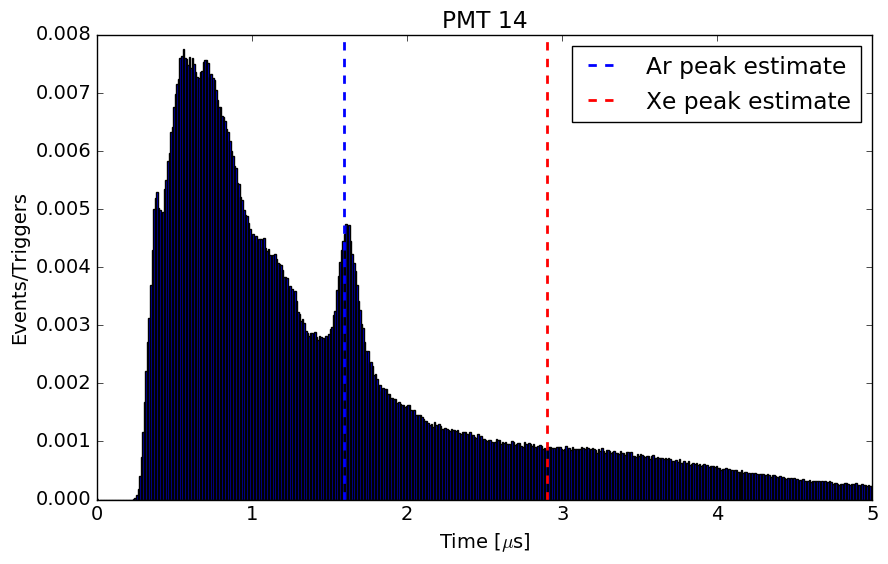

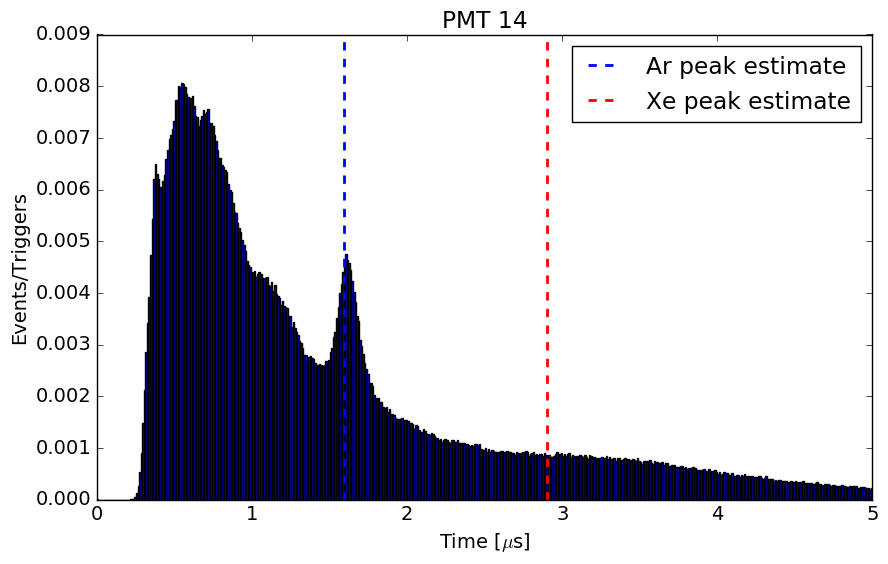

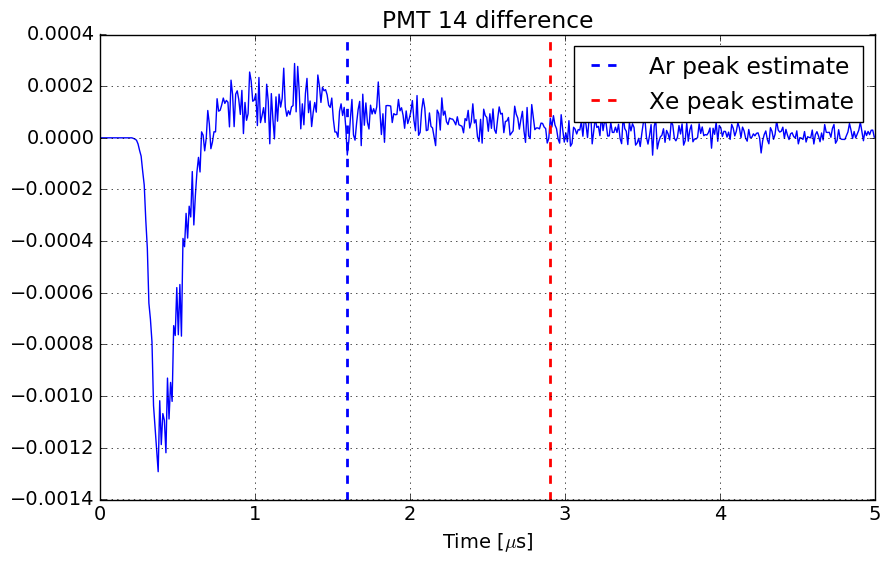

1000000it [00:42, 23782.38it/s]
1000000it [00:42, 23764.96it/s]


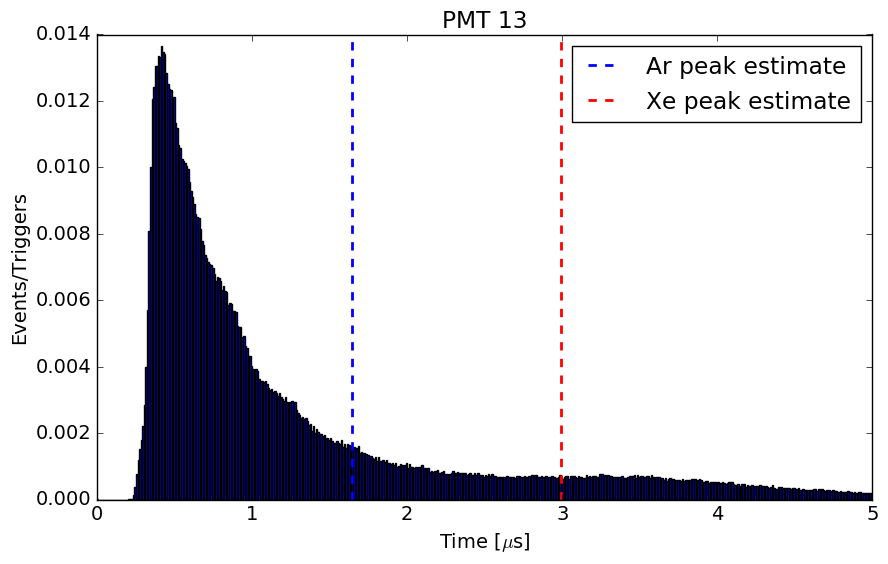

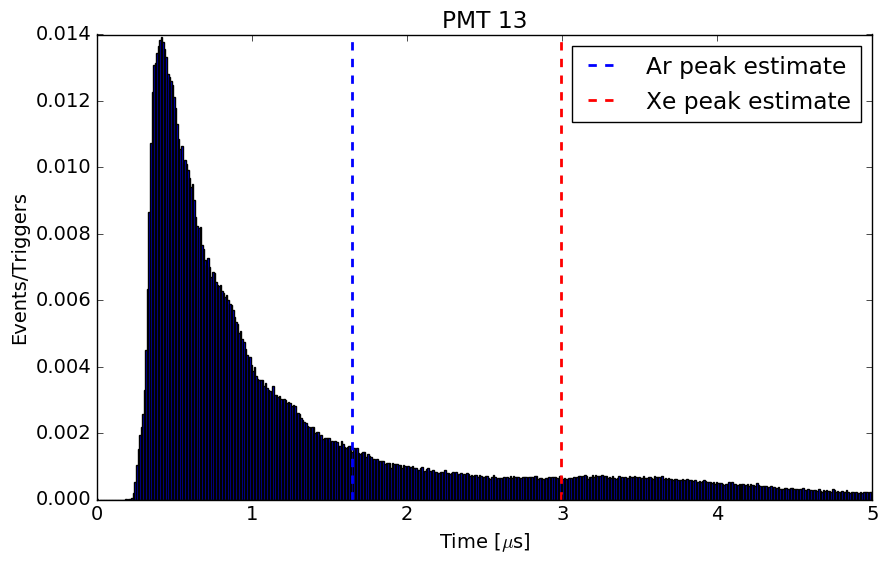

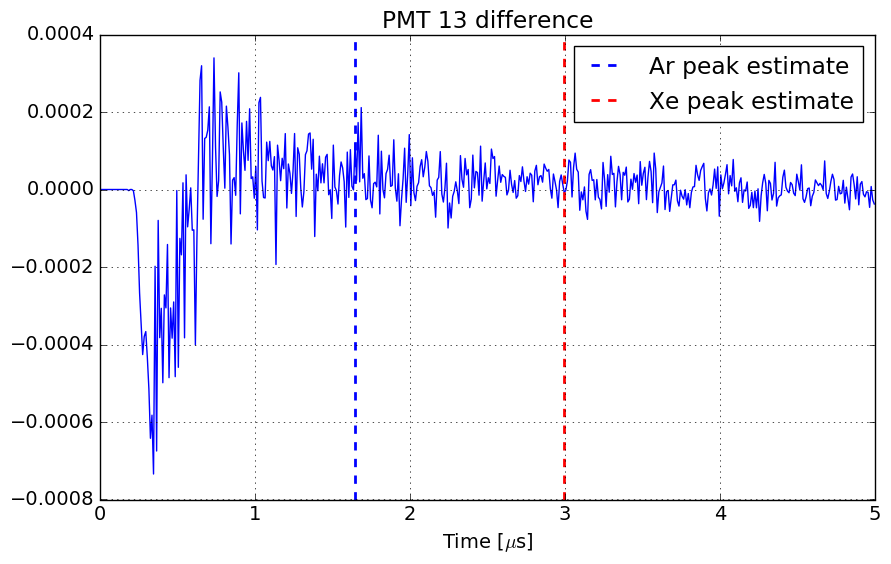

In [17]:
for file in os.listdir(path):
    if 'counts' in file:
        continue
    if 'AP_figs' in file:
        continue
    #print(file)
    channel = int(file.split("_")[1].lstrip("wf"))
    board = int(file.split("_")[2].lstrip("Board"))
    pmt = channel + 1 + board * 7
    run = int(path.split("/")[5].lstrip("run"))
    day = int(path.split("/")[7].lstrip("ap"))
    #if pmt==3:
    #    continue #ONLY THIS TIME!!! CANCEL OTHERWISE
    my_regex = r"(processed_wf"+ str(channel) + r"_Board" + str(board) +r"_AP_LED_*)"
    for file0 in path_of_files2: 
        if re.search(my_regex, file0) :
            file1 = file0
    #print(channel,board, pmt)
    #if pmt in range(0,4):
    #    continue
    #if pmt in range(5,7):
    #    continue
    #if pmt in range(8,15):
    #    continue
    AP_data_new = process_ap_file(path + file)
    AP_data_old = process_ap_file(path1 + file1)
    #AP_data = AP_data[AP_data['entropy']<0.4]
    hist_res_new = plot1dhist(AP_data_new[(AP_data_new['area']>2.) & (AP_data_new['area']<50)],pmt,fit_exp,arHV5e6[pmt-1],path)
    hist_res_old = plot1dhist(AP_data_old[(AP_data_old['area']>2.) & (AP_data_old['area']<50)],pmt,fit_exp, arHV5e6[pmt-1],path1)
    
    hist1d_diff = {'height': (hist_res_new['height']-hist_res_old['height']),
                  'bin_centres': hist_res_new['bin_centres']}
    plt.figure(figsize=(10,6))
    plt.plot(hist1d_diff['bin_centres'],hist1d_diff['height'])
    XePeak = estimateXePosition(arHV5e6[pmt-1])
    ArPeak = estimateArPosition(arHV5e6[pmt-1])
    line_up=plt.axvline(ArPeak, color='b', linestyle='dashed', linewidth=2, label = "Ar peak estimate")
    line_down=plt.axvline(XePeak, color='red', linestyle='dashed', linewidth=2, label = "Xe peak estimate")
    plt.legend(handles=[line_up, line_down])
    plt.xlabel('Time [$\mu$s]')
    plt.title('PMT %d difference' % pmt)
    plt.grid()
    axes = plt.gca()
    #axes.set_ylim([-0.1,0.1])
    #axes.set_xlim([2.5,3.2])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_difference_run6_%d.png' % (pmt,day), dpi=150, transparence = False)
    plt.show()
    

In [29]:
def fit_exp_gaus(x, Ne, a, c1, c2, Ng, sigma, mu):
    return Ne*np.exp(-a*x + c1) + c2 + Ng*sps.norm.pdf(x, loc=mu, scale = sigma)

def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[(histDF['bin_centres']>0.7)]#|(histDF['bin_centres']<0.9)) | (histDF['bin_centres']>1.6)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[800,2, 2, 10, 100, 1, 3.2])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()

250000it [00:04, 54370.19it/s]


539.009760111 1.68274785724 0.936542878778 20.153874408 32.3471503768 0.608816070267 3.3953109265


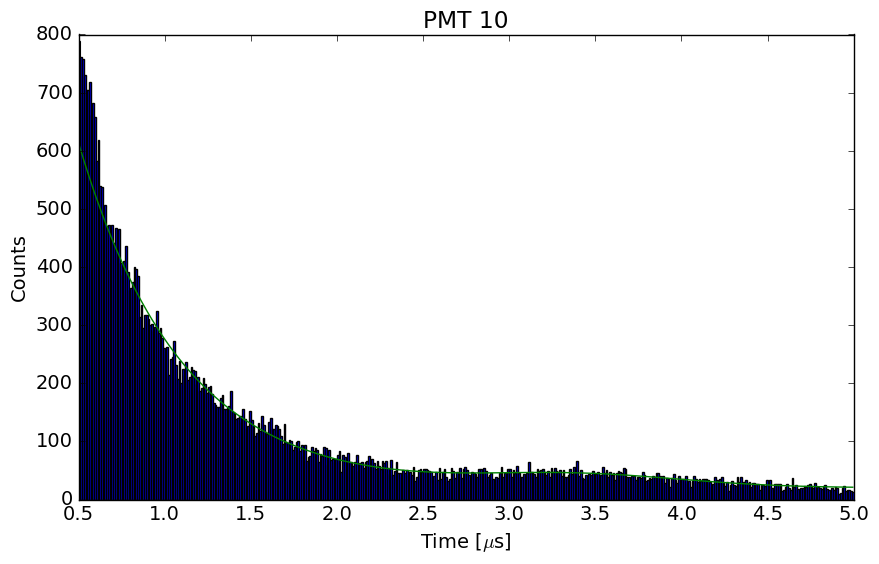

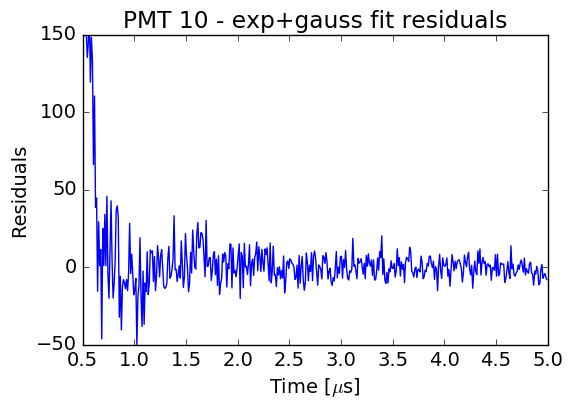

In [208]:
#for file in os.listdir(path):
#   if 'counts' in file:
#    continue
    #print(file)
file = os.listdir(path)[0]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

250000it [00:05, 47870.71it/s]


747.896522966 1.99068017047 2.07677374881 -861.727266058 11786.3194013 4.77527284594 2.82982094165


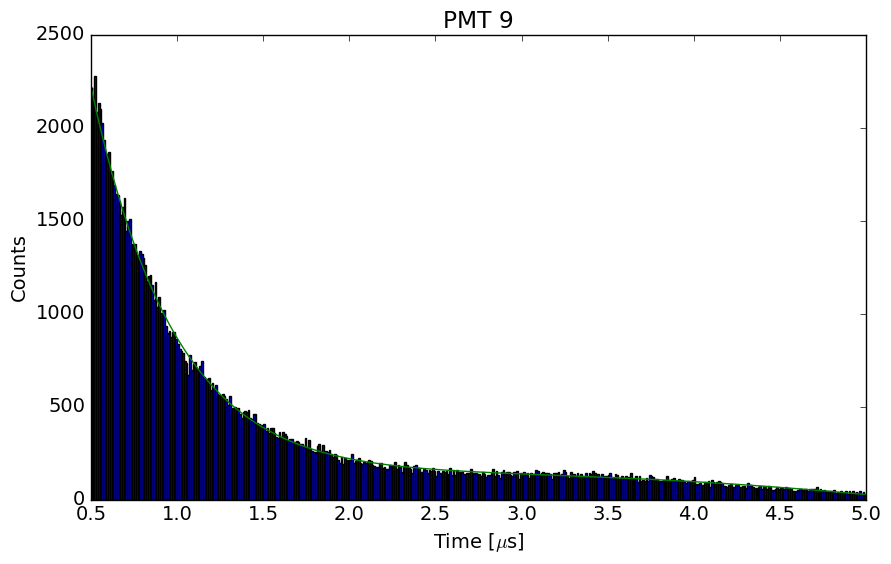

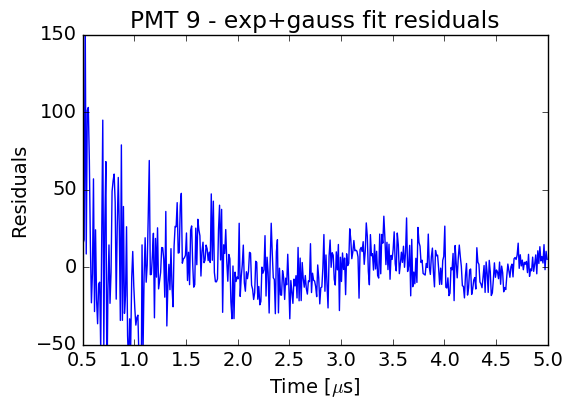

In [209]:
file = os.listdir(path)[1]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

250000it [00:05, 46077.27it/s]


4415.00679891 1.72473198238 0.354256320777 4.23700222845 442.282762486 1.45197632073 2.80873586021


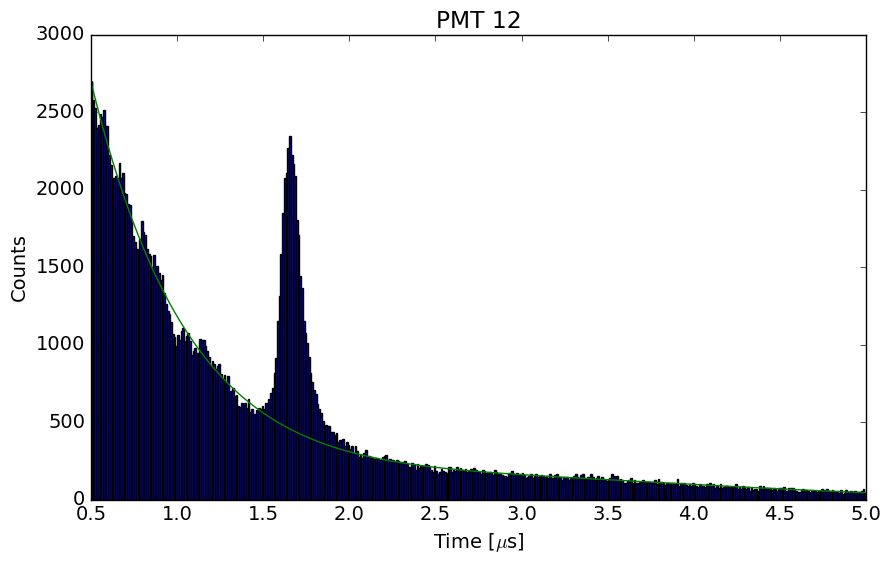

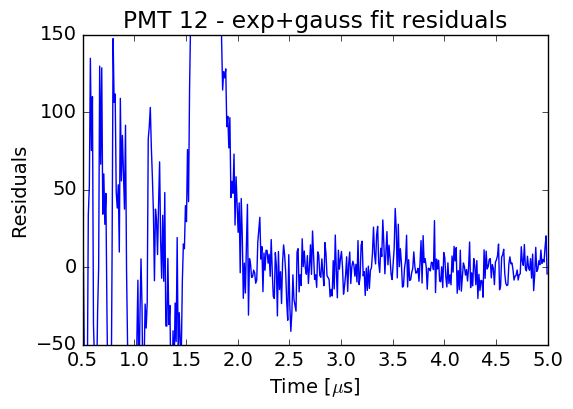

In [210]:
def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[((histDF['bin_centres']>0.5)&(histDF['bin_centres']<1.3)) | (histDF['bin_centres']>2)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[800,1.7, 1, 0, 100, 1, 3.2])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()
    
file = os.listdir(path)[2]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

250000it [00:04, 52288.30it/s]


735.058500322 1.58574428401 0.759361687824 -295.86226027 3142.63107714 3.62687402747 3.33431078549


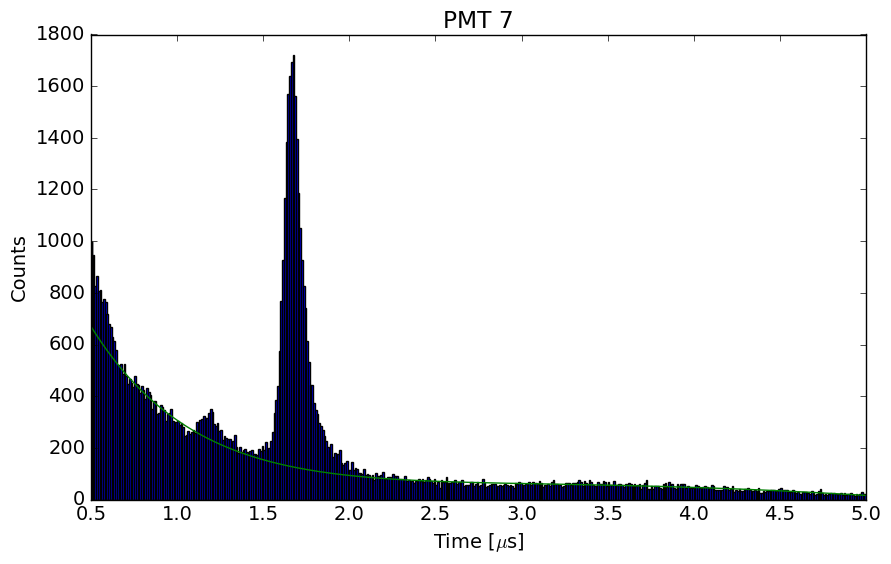

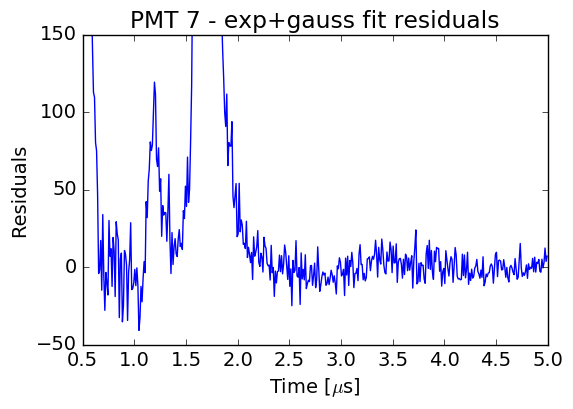

In [211]:
def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[((histDF['bin_centres']>0.65) &(histDF['bin_centres']<0.95 )) | (histDF['bin_centres']>2.1)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[880, 1.3, 1.4, 38, 200, 1.5, 3.3])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()
    
file = os.listdir(path)[3]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

250000it [00:05, 42586.55it/s]


664.623216962 1.90482076636 2.2531731479 -7.40688524023 387.063533861 1.35045866974 3.03282150376


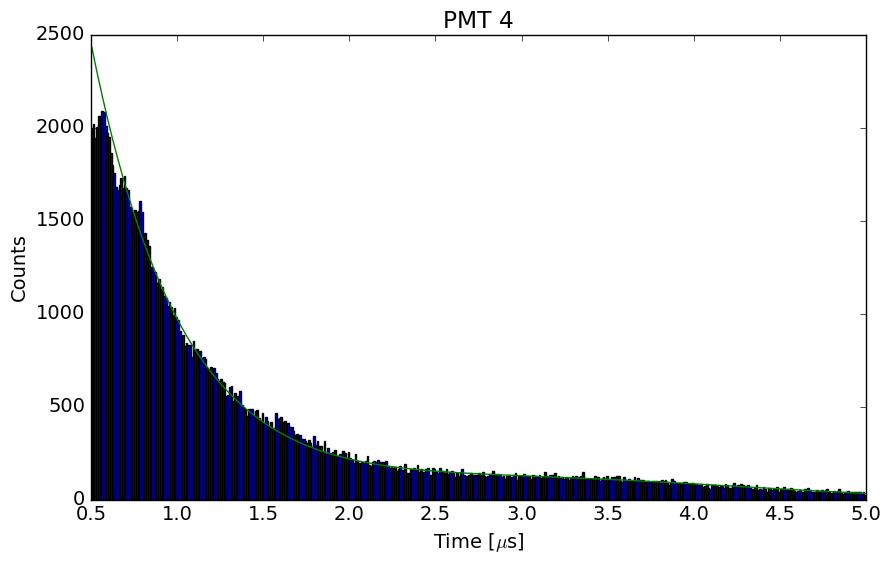

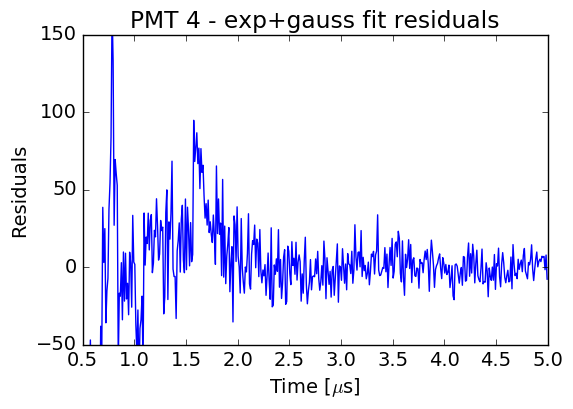

In [212]:
def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[((histDF['bin_centres']>0.8) &(histDF['bin_centres']<1.3 )) | (histDF['bin_centres']>2.1)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[400, 1, 2, 0, 1000, 1, 2])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()

file = os.listdir(path)[4]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

250000it [00:05, 43695.99it/s]


736.760937043 1.60991569056 1.87207985485 17.4261561205 240.294845685 1.28259325648 2.73018875141


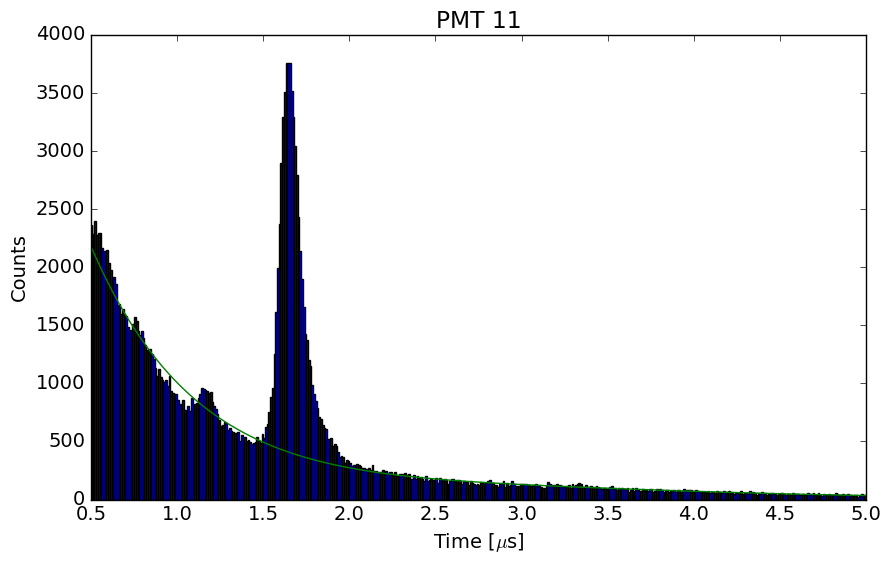

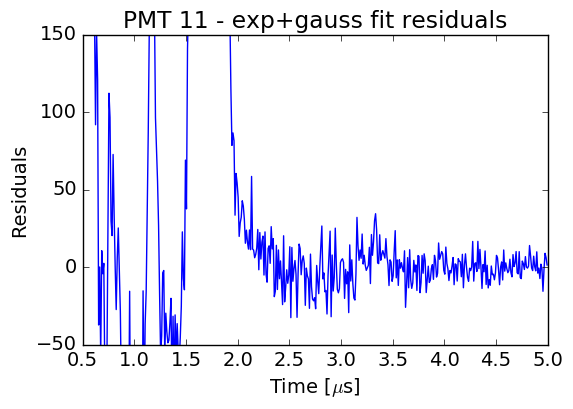

In [213]:
def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[((histDF['bin_centres']>1.27) &(histDF['bin_centres']<1.33 ))|((histDF['bin_centres']>0.65) &(histDF['bin_centres']<0.85 )) | (histDF['bin_centres']>2.1)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[900, 2, 2, 16, 1, 1000, 3.])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()

file = os.listdir(path)[6]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

In [160]:
os.listdir(path)

['processed_wf2_Board1_AP_LED_2.205V.root',
 'processed_wf1_Board1_AP_LED_2.25V.root',
 'processed_wf4_Board1_AP_LED_2.315V.root',
 'processed_wf6_Board0_AP_LED_2.12V.root',
 'processed_wf3_Board0_AP_LED_2.3V.root',
 'processed_wf0_Board1_AP_LED_2.205V.root',
 'processed_wf3_Board1_AP_LED_2.315V.root',
 'processed_wf5_Board1_AP_LED_2.12V.root',
 'AP_figs',
 'counts',
 'processed_wf5_Board0_AP_LED_2.09V.root',
 'processed_wf1_Board0_AP_LED_2.26V.root',
 'processed_wf6_Board1_AP_LED_2.12V.root',
 'processed_wf0_Board0_AP_LED_2.205V.root',
 'processed_wf2_Board0_AP_LED_2.26V.root',
 'processed_wf4_Board0_AP_LED_2.3V.root']

250000it [00:05, 49717.10it/s]


540.121011424 1.68004269856 1.49663258582 15.2390721315 121.490721104 0.829686281549 3.3765683249


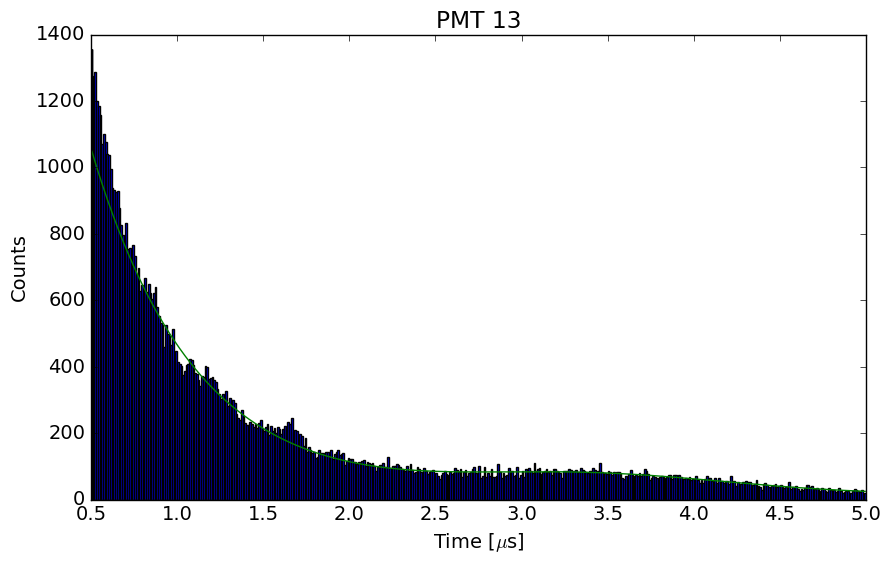

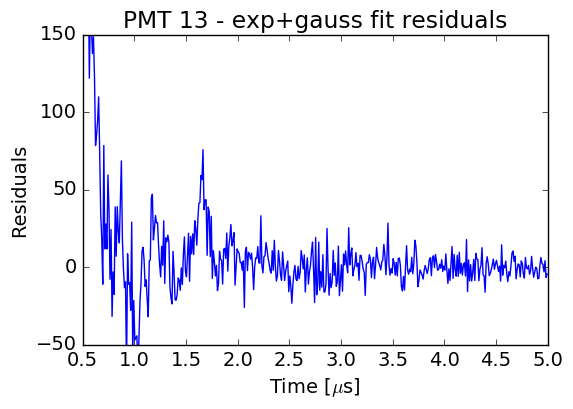

In [214]:
def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[((histDF['bin_centres']>0.8) &(histDF['bin_centres']<1.3 )) | (histDF['bin_centres']>2.1)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[800, 2, 2, 10, 200, 2, 3.3])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()

file = os.listdir(path)[7]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

#quite bad fit values... gaussian mean @1.98 (??!!)

250000it [00:04, 53017.21it/s]


418.626028652 1.65701814444 1.73170089618 14.2556627982 126.68169005 0.857319867775 3.36955454074


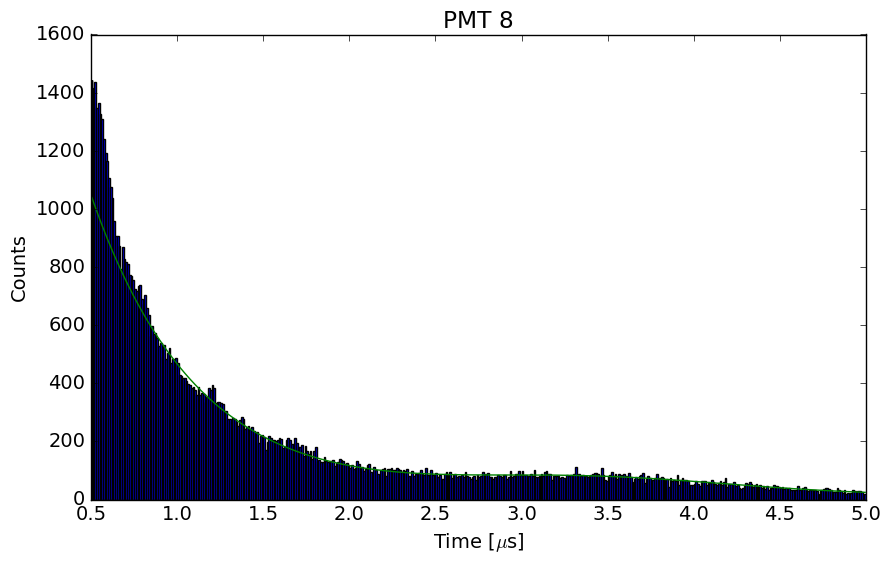

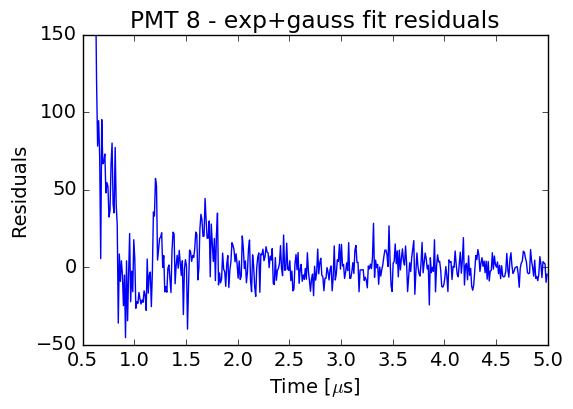

In [215]:
def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[((histDF['bin_centres']>0.8) &(histDF['bin_centres']<1.3 )) | (histDF['bin_centres']>1.8)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[600, 2, 2, 0, 150, 2, 3.0])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()

file = os.listdir(path)[5]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

250000it [00:04, 51493.55it/s]


265.614724132 1.43187459728 1.4614480793 14.8693222753 120.455410891 0.941309303621 3.34985696964


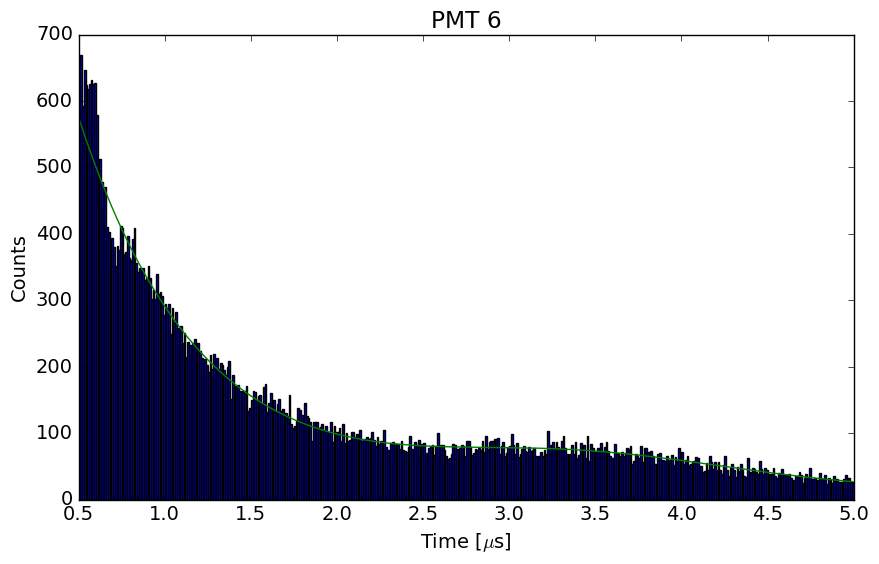

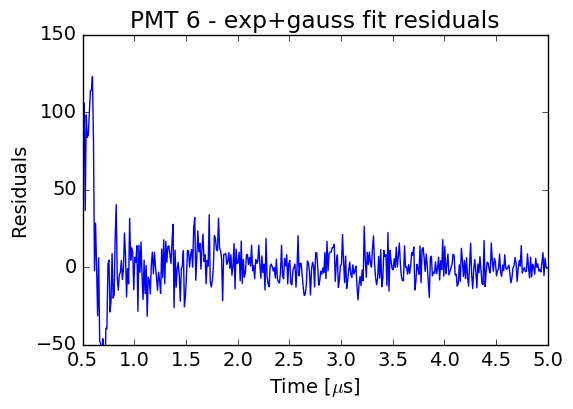

In [216]:
def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[((histDF['bin_centres']>0.8) &(histDF['bin_centres']<1.3 )) | (histDF['bin_centres']>1.8)]#define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[600, 2, 2, 0, 150, 2, 3.5])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()

file = os.listdir(path)[10]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

250000it [00:05, 47653.53it/s]


763.5436635 1.87593471726 1.87246439947 -398.236579513 4976.14495553 3.99973071555 2.77316600549


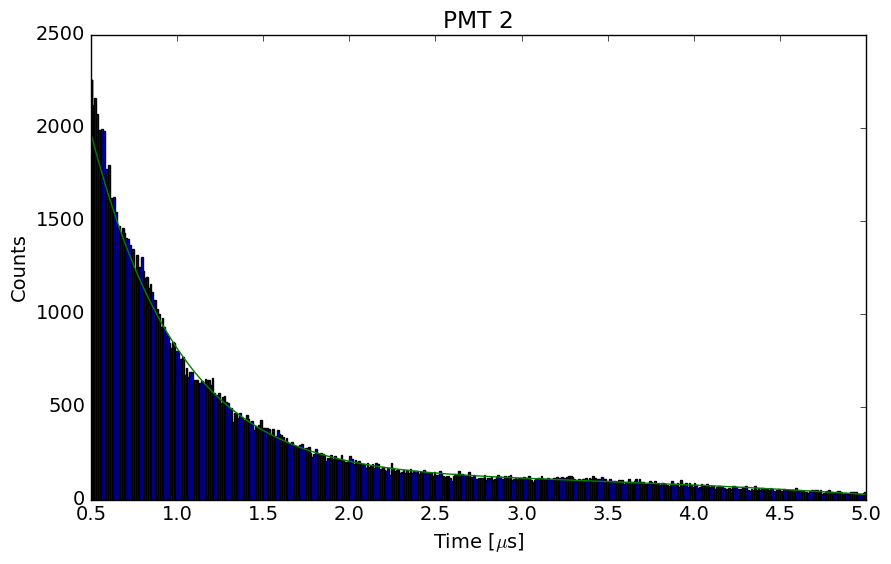

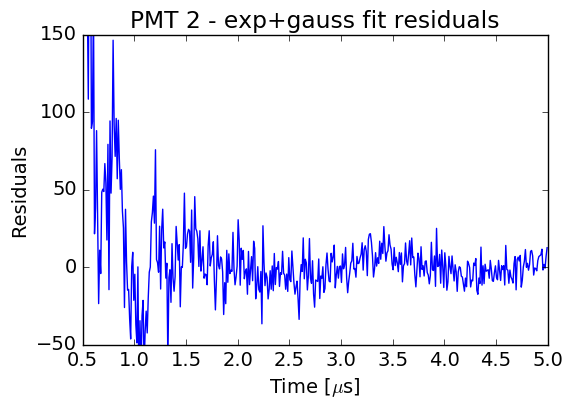

In [219]:
def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[(histDF['bin_centres']>0.85)]# &(histDF['bin_centres']<1.3 )) | (histDF['bin_centres']>1.8)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[700, 2, 2, 10, 100, 1, 3.3])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()

file = os.listdir(path)[11]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

250000it [00:05, 48056.44it/s]


432.423251233 1.60938789846 1.3763517444 -3.86889928427 153.89374975 1.13222874795 3.46226885485


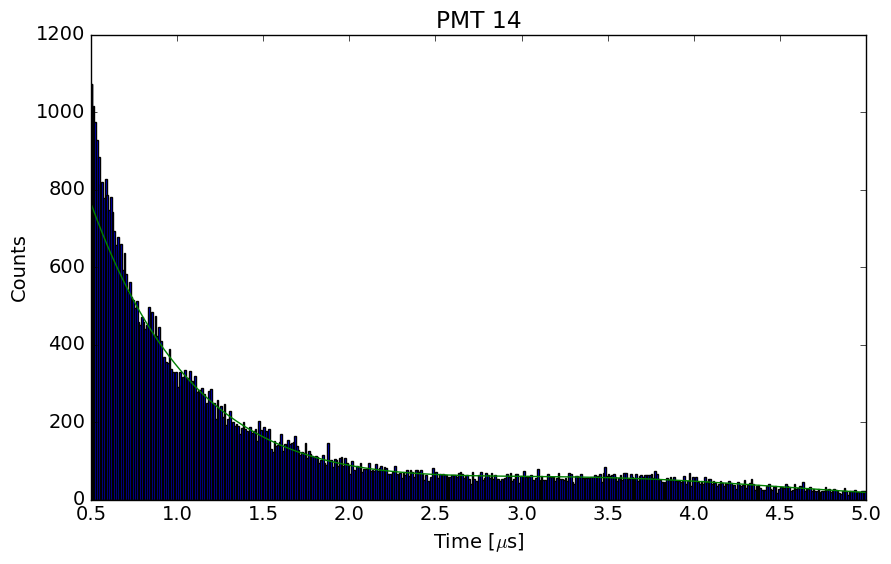

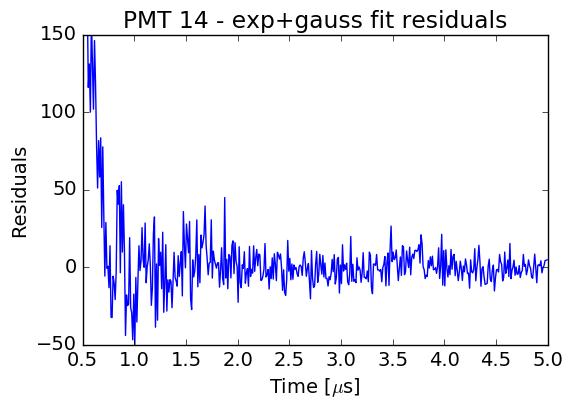

In [221]:
def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[(histDF['bin_centres']>0.7)] #| (histDF['bin_centres']>1.8)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[400, 1.7, 1, 0, 100, 1, 3.5])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()

file = os.listdir(path)[12]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

250000it [00:05, 48098.54it/s]


891.292978502 1.89461076219 1.08009990228 -16.7788839159 273.752730373 1.18610527414 3.34042507749


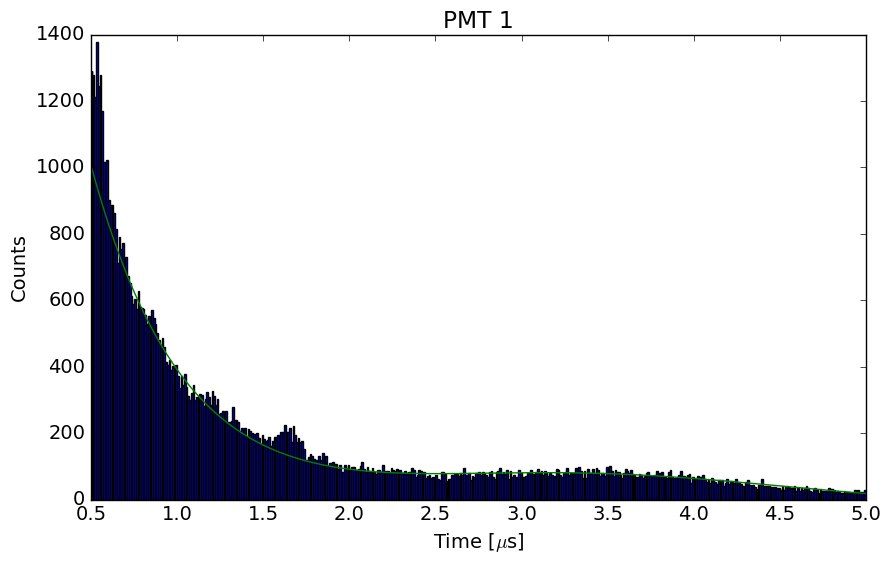

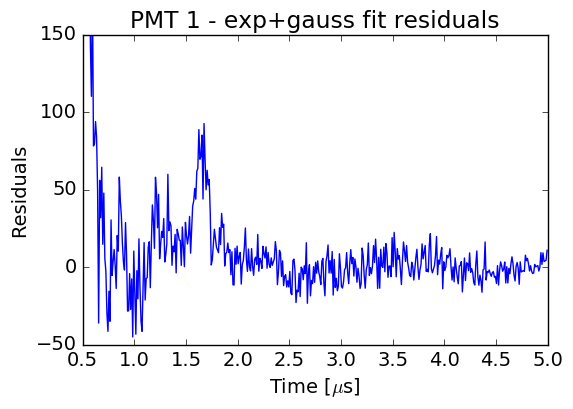

In [223]:
def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[((histDF['bin_centres']>0.7)&(histDF['bin_centres']<1.2)) | (histDF['bin_centres']>1.9)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[600, 2, 1, 0, 150, 1.5, 3.3])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()
    
file = os.listdir(path)[13]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

250000it [00:05, 46700.22it/s]


552.454964262 1.45220410125 1.6824372158 22.4460412303 76.8483213627 0.812928959498 3.42992802507


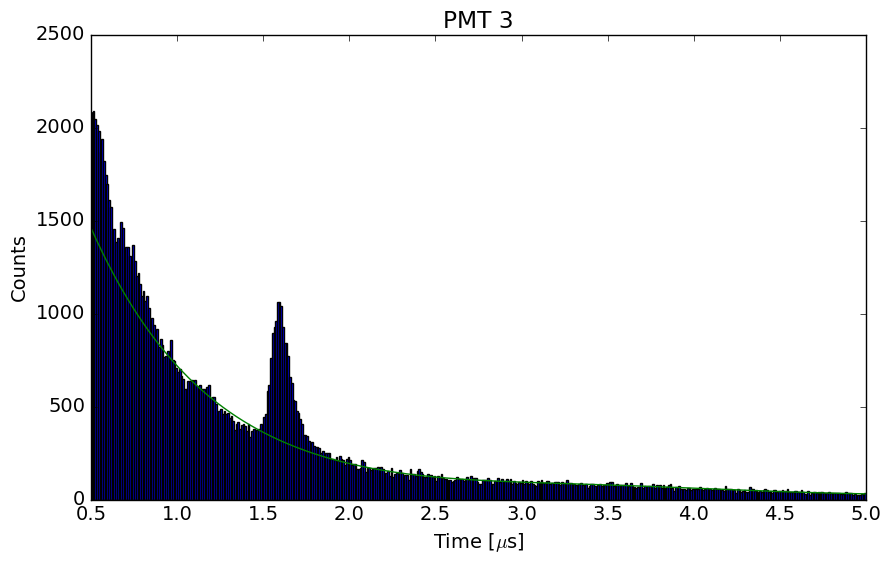

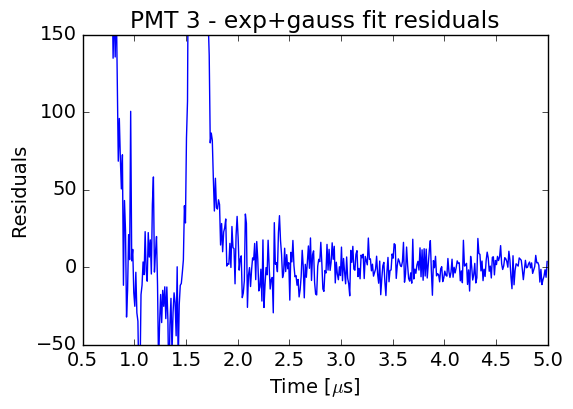

In [242]:
def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[((histDF['bin_centres']>0.89)&(histDF['bin_centres']<1.2) )| (histDF['bin_centres']>2.)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[900, 2, 2 , 0, 100, 1.2, 3.4])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()

file = os.listdir(path)[14]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

250000it [00:05, 45221.57it/s]


4602.37763538 2.04058270857 0.352102058696 -111.054654931 1354.13950292 2.44549084269 2.77216520669


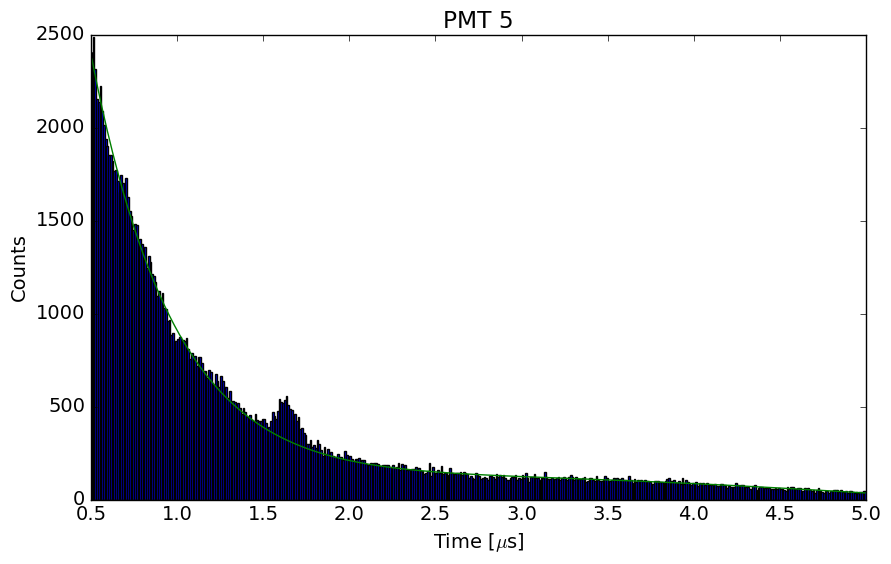

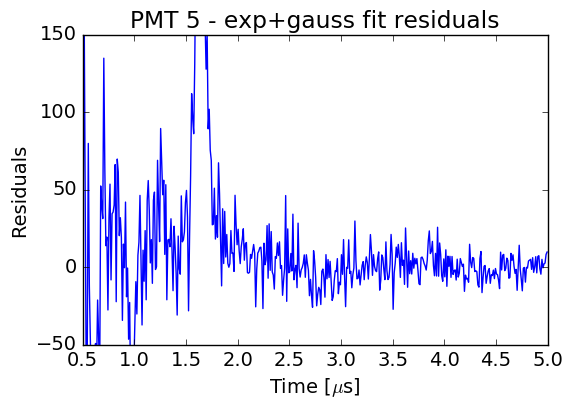

In [244]:
def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[(histDF['bin_centres']<1.) | (histDF['bin_centres']>2.1)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[1500, 2, 2, 1, 100, 1, 3])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()

file = os.listdir(path)[15]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

In [245]:
all_files = os.listdir(path)
outfile = open(path+'counts/'+'counts.txt', 'w')
outfile.write("######################\n")
outfile.write("The numbers are as folows:\n")
outfile.write("PMT#\n")
outfile.write("Counts in left sideband (2.31 to 2.67)#\n")
outfile.write("Counts in left sideband (2.4 to 2.67)#\n")
outfile.write("Counts in left sideband (2.49 to 2.67)#\n")
outfile.write("Counts in left sideband (2.58 to 2.67)#\n")
outfile.write("Counts in right sideband (3.03 to 3.12)#\n")
outfile.write("Counts in right sideband (3.03 to 3.21)#\n")
outfile.write("Counts in right sideband (3.03 to 3.3)#\n")
outfile.write("Counts in left sideband (3.03 to 3.39)#\n")
outfile.write("Counts in signalband (2.67 to 3.03)#\n")
outfile.write("Threshold\n")
outfile.write("######################\n")
for file in os.listdir(path):
    if 'counts' in file:
        continue
    if 'AP_figs' in file:
        continue
    
    threshold=2
    filename = file
    channel = int(file.split("_")[1].lstrip("wf"))
    board = int(file.split("_")[2].lstrip("Board"))
    pmt = channel + 1 + board * 7
    print(path + filename)
    DataFrame = process_ap_file(path + filename)
    
    """
    def apply_selection(row):
        global counter_sig
        global counter_up1
        global counter_up2
        global counter_up3
        global counter_low1
        global counter_low2
        global counter_low3
        pos_j = row.time/100. -2.
        if not row.area > threshold:
            return
        if pos_j<2.67 and pos_j>2.4:
            counter_low1 +=1
        if pos_j<2.67 and pos_j>2.49:
            counter_low2 +=1
        if pos_j<2.67 and pos_j>2.58:
            counter_low3 +=1
        if pos_j<3.12 and pos_j>3.03:
            counter_up1 +=1
        if pos_j<3.21 and pos_j>3.03:
            counter_up2 +=1
        if pos_j<3.3 and pos_j>3.03:
            counter_up3 +=1
        if pos_j<3.03 and pos_j>2.67:
            counter_sig +=1
        return
    
    DataFrame.apply(apply_selection, axis=1)
    """
    
    above_threshold = DataFrame[DataFrame.area > threshold]
    
    
    counter_low1 = ((above_threshold.time/100.-2. > 2.4) & (above_threshold.time/100.-2. < 2.67)).sum()
    counter_low2 = ((above_threshold.time/100.-2. > 2.49) & (above_threshold.time/100.-2. < 2.67)).sum()
    counter_low3 = ((above_threshold.time/100.-2. > 2.58) & (above_threshold.time/100.-2. < 2.67)).sum()
    counter_low4 = ((above_threshold.time/100.-2. > 2.31) & (above_threshold.time/100.-2. < 2.67)).sum()
    
    counter_up1 = ((above_threshold.time/100.-2. > 3.03) & (above_threshold.time/100.-2. < 3.12)).sum()
    counter_up2 = ((above_threshold.time/100.-2. > 3.03) & (above_threshold.time/100.-2. < 3.21)).sum()
    counter_up3 = ((above_threshold.time/100.-2. > 3.03) & (above_threshold.time/100.-2. < 3.3)).sum()
    counter_up4 = ((above_threshold.time/100.-2. > 3.03) & (above_threshold.time/100.-2. < 3.39)).sum()
    
    counter_sig = ((above_threshold.time/100.-2. > 2.67) & (above_threshold.time/100.-2. < 3.03)).sum()

    
    """
    for j in range(len(DataFrame['time'])):
        pos_j=DataFrame.time[j]/100.-2.
        area_j=DataFrame.area[j]
        #print(pos_j,area_j)
        if pos_j<2.67 and pos_j>2.4 and area_j>threshold:
            counter_low1 +=1
        if pos_j<2.67 and pos_j>2.49 and area_j>threshold:
            counter_low2 +=1
        if pos_j<2.67 and pos_j>2.58 and area_j>threshold:
            counter_low3 +=1
        if pos_j<3.12 and pos_j>3.03 and area_j>threshold:
            counter_up1 +=1
        if pos_j<3.21 and pos_j>3.03 and area_j>threshold:
            counter_up2 +=1
        if pos_j<3.3 and pos_j>3.03 and area_j>threshold:
            counter_up3 +=1
        if pos_j<3.03 and pos_j>2.67 and area_j>threshold:
            counter_sig +=1
    """
    #plot(DataFrame, pmt)
    outfile.write("%d %d %d %d %d %d %d %d %d %d %d\n" % (pmt,counter_low4,counter_low1,counter_low2,counter_low3,counter_up1,counter_up2,counter_up3,counter_up4,counter_sig,threshold))
outfile.close()



2183it [00:00, 21825.70it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf2_Board1_AP_LED_2.205V.root


250000it [00:04, 52900.24it/s]
3634it [00:00, 36325.23it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf1_Board1_AP_LED_2.25V.root


250000it [00:05, 49465.81it/s]
3507it [00:00, 35063.01it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf4_Board1_AP_LED_2.315V.root


250000it [00:04, 50172.18it/s]
3298it [00:00, 32973.82it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf6_Board0_AP_LED_2.12V.root


250000it [00:04, 52597.04it/s]
3952it [00:00, 39350.23it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf3_Board0_AP_LED_2.3V.root


250000it [00:05, 47684.35it/s]
3469it [00:00, 34678.95it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf0_Board1_AP_LED_2.205V.root


250000it [00:04, 50476.57it/s]
3063it [00:00, 30621.41it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf3_Board1_AP_LED_2.315V.root


250000it [00:05, 49697.47it/s]
3165it [00:00, 31417.15it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf5_Board1_AP_LED_2.12V.root


250000it [00:04, 52382.30it/s]
3645it [00:00, 36272.83it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf5_Board0_AP_LED_2.09V.root


250000it [00:04, 54624.20it/s]
3260it [00:00, 32561.22it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf1_Board0_AP_LED_2.26V.root


250000it [00:04, 50620.72it/s]
4222it [00:00, 42181.92it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf6_Board1_AP_LED_2.12V.root


250000it [00:04, 53907.50it/s]
3462it [00:00, 34607.00it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf0_Board0_AP_LED_2.205V.root


250000it [00:04, 54296.31it/s]
3699it [00:00, 36980.60it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf2_Board0_AP_LED_2.26V.root


250000it [00:04, 50647.01it/s]
3059it [00:00, 30452.52it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf4_Board0_AP_LED_2.3V.root


250000it [00:05, 49520.93it/s]
